# Load and process data

In [177]:
import datetime
import gspread
import matplotlib.pyplot as plt
from mizani.formatters import scientific_format
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import numpy as np
import os
import pandas as pd
from plotnine import *
import sys
import warnings
from scipy import stats
from statistics import mean
import itertools
import statsmodels


# scikit-misc for loess smoothing
!pip install scikit-misc
!pip install scikit-posthocs
import skmisc
import scikit_posthocs

# for linear regression
from sklearn import linear_model
from sklearn import metrics

%matplotlib inline

# New code for auth
from google.colab import auth, drive
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# import custom modules from github
drive.mount('/content/gdrive')

# set display options for tables in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# define parent directory
parent_dir = '/content/gdrive/My Drive/WBE_UCB_Rebecca/Kara + Rebecca + Rose/Paper/Files'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Paths

Input paths precprocessing

In [178]:
## Original wastewater file:
wastewater_path_orig = f'{parent_dir}/Preprocessing/full_wastewater_dataset_aggregated_newformat.csv'

flow_log_path = f'{parent_dir}/Preprocessing/flow_log.csv'
precip_folder_path = f'{parent_dir}/Preprocessing/Precipitation/'

## Testing data:
testfile_path = f'{parent_dir}/Preprocessing/diagnostic_testing_data.csv'

## Case data:
cases_path = f'{parent_dir}/Preprocessing/case_data.csv' # This file is not made available

Output paths preprocessing

In [179]:
## Processed wastewater files:
wastewater_path = f'{parent_dir}/Preprocessing/full_wastewater_dataset_processed.csv'
site_lookup_path = f'{parent_dir}/Preprocessing/site_lookup.csv'

site_lookup_with_flow_path = f'{parent_dir}/Preprocessing/site_lookup_with_flow.csv'
N1_flow_normalized_path = f'{parent_dir}/Preprocessing/N1_flow_normalized.csv'
all_processed_path = f'{parent_dir}/Preprocessing/flow_cases_processed.csv'

metadata_path = f'{parent_dir}/Preprocessing/metadata_selection.xlsx'
metadata_full_path = f'{parent_dir}/Preprocessing/metadata_full.xlsx'

cases_long_path = f'{parent_dir}/Preprocessing/cases_long.csv'

Output paths analysis

In [180]:
corr_path = f'{parent_dir}/Analysis/correlation_kendall_log_values.xlsx'
fig1_path = f'{parent_dir}/Analysis/Figures/Figure 1.png'
fig2_path = f'{parent_dir}/Analysis/Figures/Figure 2_'
fig3_path = f'{parent_dir}/Analysis/Figures/Figure 3.png'
fig4_path = f'{parent_dir}/Analysis/Figures/Figure_4.png'
fig5_path = f'{parent_dir}/Analysis/Figures/Figure 5.png'
figS1_path = f'{parent_dir}/Analysis/Figures/Figure S1_'
figS2_path = f'{parent_dir}/Analysis/Figures/Figure S2_'
figS3_path = f'{parent_dir}/Analysis/Figures/Figure S3.png'
figSX_path = f'{parent_dir}/Analysis/Figures/Fig_S4.png'
fig5_new_path = f'{parent_dir}/Analysis/Figures/Figure S5.png'

tableS7_path = f'{parent_dir}/Analysis/Table S7.csv'

bias_comp_corr_path = f'{parent_dir}/Analysis/correlation_omicron_testing_compensated_log.xlsx'
capacity_comp_corr_path = f'{parent_dir}/Analysis/correlation_kendall_testing_compensated_no_bias.xlsx'
shifted_corr_path = f'{parent_dir}/Analysis/correlation_kendall_shifted_'
variant_maxima_path = f'{parent_dir}/Analysis/variant_maxima.csv'

R2_path = f'{parent_dir}/Analysis/R2_summary.csv'

In [181]:
# Define variant timeframes globally
variant_timeframes = pd.DataFrame(index=['all','pre_delta','epsilon_alpha','delta','omicron_BA1'],columns=['start','end'])
variant_timeframes.loc['all'] = [pd.Timestamp('01-10-2020'),pd.Timestamp('15-03-2022')]
variant_timeframes.loc['pre_delta'] = [pd.Timestamp('01-10-2020'),pd.Timestamp('15-04-2021')]
variant_timeframes.loc['epsilon_alpha'] = [pd.Timestamp('01-01-2021'),pd.Timestamp('15-04-2021')]
variant_timeframes.loc['delta'] = [pd.Timestamp('16-04-2021'),pd.Timestamp('26-11-2021')]
variant_timeframes.loc['omicron_BA1'] = [pd.Timestamp('27-11-2021'),pd.Timestamp('15-03-2022')]

# Preprocessing

## Preprocess wastewater data

Read original wastewater files

In [182]:
wastewater_data_orig = pd.read_csv(wastewater_path_orig)
site_lookup = pd.read_csv(site_lookup_path)

Define data types

In [183]:
# Filter wastewater dataset by only N1
N1 = wastewater_data_orig.loc[~(wastewater_data_orig.measurement == 'N1_per_PMMoV')]
print(N1.head(1))
# Set data types
N1 = N1.astype({'sample_code':'string',
                'date_sampling':'datetime64[ns]',
                'sample_level':'string',
                'county':'string',
                'measurement':'string',
                'replicate':'object',
                'quality_score':'object',
                'detected_of_3_TechReps':'object',
                'value':'object',
                'gmean_value':'float',
                'gstd_value':'float',
                'gmean_value_upper':'float',
                'gmean_value_lower':'float'
                })

# Sort dataframe
N1.sort_values(['sample_code','date_sampling'],ascending=[True,True],inplace=True)

# Delete empty values
N1.dropna(subset=['gmean_value'],inplace=True)
print(N1.head(1))

  sample_code date_sampling sample_level    county              measurement  \
1           A    2020-10-02     Influent  County 6  SARS_CoV_2_N1_gc_per_mL   

  replicate quality_score detected_of_3_TechReps                value  \
1     ['1']        [60.0]                    [3]  [2.057956928332534]   

   gmean_value  gstd_value  gmean_value_upper  gmean_value_lower  
1     2.057957         NaN                NaN                NaN  
  sample_code date_sampling sample_level    county              measurement  \
1           A    2020-10-02     Influent  County 6  SARS_CoV_2_N1_gc_per_mL   

  replicate quality_score detected_of_3_TechReps                value  \
1     ['1']        [60.0]                    [3]  [2.057956928332534]   

   gmean_value  gstd_value  gmean_value_upper  gmean_value_lower  
1     2.057957         NaN                NaN                NaN  


Add sewershed data

In [184]:
N1 = N1.merge(site_lookup[['sample_code','sampling_days','site_pretreatment','site_population_served','percent_industrial_flow']],on='sample_code',how='left')

Calculate sample size (number of samples at each sewershed)

In [185]:
## Calculate number of SARS-CoV-2 measurements for each site
sample_codes = N1.sample_code.unique()
for code in sample_codes:
  N1_SARS = N1[(N1.sample_code == code) & (N1.measurement == 'SARS_CoV_2_N1_gc_per_mL')] # only count SARS-CoV-2 measurements
  n = N1_SARS.sample_code.value_counts()[code]
  N1.loc[(N1.sample_code == code), 'n_sample_size'] = n # save value in N1 dataframe
N1.dropna(subset=['n_sample_size'],inplace=True) # drop empty values
N1.n_sample_size = N1.n_sample_size.astype('int') # define data type
print(N1.head(2))

  sample_code date_sampling sample_level    county              measurement  \
0           A    2020-10-02     Influent  County 6  SARS_CoV_2_N1_gc_per_mL   
1           A    2020-10-02     Influent  County 6          pmmov_gc_per_mL   

  replicate quality_score detected_of_3_TechReps                 value  \
0     ['1']        [60.0]                    [3]   [2.057956928332534]   
1     ['1']        [60.0]                    [3]  [3682.7608316923656]   

   gmean_value  gstd_value  gmean_value_upper  gmean_value_lower  \
0     2.057957         NaN                NaN                NaN   
1  3682.760832         NaN                NaN                NaN   

  sampling_days site_pretreatment  site_population_served  \
0       Tuesday               NaN                  8400.0   
1       Tuesday               NaN                  8400.0   

   percent_industrial_flow  n_sample_size  
0                      0.0             43  
1                      0.0             43  


Calculate wastewater dataset statistics / metadata

In [186]:
N1_meta = N1[['sample_code','sample_level','county','n_sample_size','site_population_served','sampling_days','percent_industrial_flow']].drop_duplicates(subset='sample_code') # Get list of sampling sites

start = N1[['sample_code','date_sampling']].groupby(['sample_code']).min().astype('datetime64[ns]') # Get earliest measurement date
start.rename(columns={'date_sampling':'start_date'},inplace=True)
start = start.start_date.dt.date
N1_meta = N1_meta.merge(start,'left', on='sample_code') # Add to df

end = N1[['sample_code','date_sampling']].groupby(['sample_code']).max().astype('datetime64[ns]') # Get latest measurement date
end.rename(columns={'date_sampling':'end_date'},inplace=True)
end = end.end_date.dt.date
N1_meta = N1_meta.merge(end,'left', on='sample_code') # Add to df

g_median = round(N1.loc[N1.measurement == 'SARS_CoV_2_N1_gc_per_mL'][['sample_code','gmean_value']]
                 .groupby(['sample_code']).median())      # Get median gene concentration
g_median.rename(columns={'gmean_value':'g_median'},inplace=True)
N1_meta = N1_meta.merge(g_median,'left', on='sample_code') # Add to df

g_median = round(N1.loc[N1.measurement == 'SARS_CoV_2_N1_gc_per_mL'][['sample_code','gmean_value']]
                 .groupby(['sample_code']).mean())      # Get mean gene concentration
g_median.rename(columns={'gmean_value':'g_mean'},inplace=True)
N1_meta = N1_meta.merge(g_median,'left', on='sample_code') # Add to df

g_std = round(N1.loc[N1.measurement == 'SARS_CoV_2_N1_gc_per_mL'][['sample_code','gmean_value']]
              .groupby(['sample_code']).std())          # Get standard deviation of gene concentration
g_std.rename(columns={'gmean_value':'g_std'},inplace=True)
N1_meta = N1_meta.merge(g_std,'left', on='sample_code') # Add to df

N1_meta['g_rel_std'] = round((N1_meta.g_std / N1_meta.g_mean),1)

# Groupby week and count
median_sampling_frequency = pd.DataFrame(columns=['median_sampling_freq','mean_sampling_freq'],index=N1.sample_code.unique()) # Create new df for results
for sample_code in N1.sample_code.unique(): # Iterate over sites
  N1_groupby = N1.loc[(N1.sample_code == sample_code)&(N1.measurement == 'SARS_CoV_2_N1_gc_per_mL')][['date_sampling','gmean_value']] # Filter dataframe by site and only SARS-CoV-2 measurements
  rng = pd.date_range(start=N1_groupby.date_sampling.min(), end=N1_groupby.date_sampling.max()) # Define date range of measurements
  index_df = pd.DataFrame(index=rng,columns=['gmean_value']) # Get new dataframe with all dates in range
  N1_groupby.set_index('date_sampling',inplace=True) # Set dates as index for filtered dataframe
  N1_groupby = N1_groupby.reindex_like(index_df) # Reindex filtered dataframe to include all dates
  N1_groupby_median = N1_groupby['gmean_value'].groupby(pd.Grouper(freq='W')).count().median() # Group by week and calculate median
  N1_groupby_mean = N1_groupby['gmean_value'].groupby(pd.Grouper(freq='W')).count().mean() # Group by week and calculate mean
  median_sampling_frequency.loc[sample_code,'median_sampling_freq'] = int(N1_groupby_median) # Save median sampling frequency of each site in results dataframe
  median_sampling_frequency.loc[sample_code,'mean_sampling_freq'] = round(N1_groupby_mean,3) # Save mean sampling frequency of each site in results dataframe
median_sampling_frequency.reset_index(inplace=True) # Reset index of results dataframe to get sample codes as column
median_sampling_frequency.rename(columns={'index':'sample_code'},inplace=True) # Rename index column to sample code column
N1_meta = N1_meta.merge(median_sampling_frequency,how='left',on=['sample_code']) # Merge sampling frequency stats onto metadata dataframe

N1_meta.site_population_served = round(N1_meta.site_population_served.astype('float')) # adapt data type


Add median testing data to metadata, calculate rolling average tests, add rolling average tests to N1

In [187]:
# Add testing data
tests = pd.read_csv(testfile_path)
tests.date_sampling = tests.date_sampling.astype('datetime64[ns]')
median_tests = round(tests[['county','total_tests_by_pop']].groupby('county').median())
N1_meta = N1_meta.merge(median_tests,how='left',on=['county'])

Save metadata file

In [188]:
N1_meta.to_excel(metadata_full_path,index=False)

Site selection for analysis

In [189]:
# Remove sites without population info (key=9), residential sites, sites with fewer than 21 samples
N1 = N1.loc[(N1.site_population_served > 9) & 
            (N1.sample_level != 'Residential') & 
            (N1.n_sample_size.astype('float') > 20)]

Site selection for metadata

In [190]:
# Remove sites without population info (key=9), residential sites, sites with fewer than 20 samples
N1_select_meta = N1_meta.loc[(N1_meta.site_population_served > 9) & 
                             (N1_meta.sample_level != 'Residential') & 
                             (N1_meta.n_sample_size.astype('float') > 20)]

N1_select_meta.to_excel(metadata_path,index=False)

Save processed wastewater file

In [191]:
# Sort dataframe
N1.sort_values(['sample_code','date_sampling'],ascending=[True,True],inplace=True)
N1.to_csv(wastewater_path,index=False)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Process flow and precipitation data

Copy processed wastewater data

In [192]:
wastewater_data = N1.copy()

Read flow data

In [193]:
flow_log = pd.read_csv(flow_log_path)
flow_log.date_sampling = flow_log.date_sampling.astype('datetime64[ns]')
print(flow_log.head(1))

  sample_code date_sampling  Flow
0           R    2021-01-14  7.33


Read wastewater data

In [194]:
# Filter wastewater dataset by only N1
N1 = N1.loc[N1.measurement == 'SARS_CoV_2_N1_gc_per_mL']
print(N1.head(1))

  sample_code date_sampling sample_level    county              measurement  \
0           A    2020-10-02     Influent  County 6  SARS_CoV_2_N1_gc_per_mL   

  replicate quality_score detected_of_3_TechReps                value  \
0     ['1']        [60.0]                    [3]  [2.057956928332534]   

   gmean_value  gstd_value  gmean_value_upper  gmean_value_lower  \
0     2.057957         NaN                NaN                NaN   

  sampling_days site_pretreatment  site_population_served  \
0       Tuesday               NaN                  8400.0   

   percent_industrial_flow  n_sample_size  
0                      0.0             43  


Merge with flow

In [195]:
# Merge N1 and flow
N1_flow = N1.merge(flow_log, how='left', on=['sample_code', 'date_sampling'])
print(N1_flow.head(1))

  sample_code date_sampling sample_level    county              measurement  \
0           A    2020-10-02     Influent  County 6  SARS_CoV_2_N1_gc_per_mL   

  replicate quality_score detected_of_3_TechReps                value  \
0     ['1']        [60.0]                    [3]  [2.057956928332534]   

   gmean_value  gstd_value  gmean_value_upper  gmean_value_lower  \
0     2.057957         NaN                NaN                NaN   

  sampling_days site_pretreatment  site_population_served  \
0       Tuesday               NaN                  8400.0   

   percent_industrial_flow  n_sample_size  Flow  
0                      0.0             43  0.49  


Process precipitation data

Compile precipitation data by county

In [196]:
# Iterate over county precipitation file and choose the maximum rainfall for each date
full_precip = pd.DataFrame()
suffix = "_precip_2021.csv"
# Read all precipitation files for 2021 in folder
for filename in os.listdir(precip_folder_path):
  if filename.endswith(suffix):
    filepath = precip_folder_path + filename
    county_precip = pd.read_csv(filepath,sep=',')
    # Find maximum precipitation for each date, if 0.2 or below, assume 0 (noise)
    max_precip = county_precip.groupby(['date_sampling']).max()
    max_precip.loc[max_precip.PRCP <= 0.2] = 0
    # Read county name from file name
    county = filename[:-len(suffix)]
    # Save county name with daily maximum precipitation
    max_precip.loc[:,'county'] = county
    max_precip = max_precip[['PRCP', 'county']].copy()
    # Change datatype 'DATE' column for join
    max_precip.reset_index(inplace=True)
    max_precip.DATE = max_precip.date_sampling.astype('datetime64[ns]')
    # Add this county's data to full df
    full_precip = pd.concat([full_precip, max_precip])

full_precip.dropna(inplace=True)
print(full_precip.head(1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  date_sampling  PRCP     county
0    2020-01-01   0.0  County 10


Calculate days since last rain event for flow normalization (to get dry median flow and for flow normalization method 2)

In [197]:
# Define temporary dataframe
county_PRCP = pd.DataFrame()
# Get all county names
counties = full_precip.county.unique()
# Get days since last rain for flow normalization method 2
for it_county in counties:
  county_temp = full_precip.loc[full_precip.county == it_county].copy() # Read county precipitation
  county_temp.date_sampling = county_temp.date_sampling.astype('datetime64[ns]') # Set datetime data type
  county_temp.set_index('date_sampling',inplace=True) # Set date as index
  days_since_rain = pd.DataFrame(columns=['days_since_rain'],index=county_temp.index) # Create empty dataframe with same index for result
  start = True # Key to skip first date for iteration
  for index, row in county_temp.iterrows():
    current_date = index
    if start == True: # Assume first date is rainy (otherwise iteration doesn't work)
      days_since_rain.loc[current_date,'days_since_rain'] = 0
      start = False
    else:
      prev_date = index - datetime.timedelta(days=1)
      if row.PRCP > 0: # if today is rainy, set 0 days since last rain
        days_since_rain.loc[current_date,'days_since_rain'] = 0
      else: # if today is dry, add 1 day to yesterday's value (one more day since last rain)
        days_since_rain.loc[current_date,'days_since_rain'] = days_since_rain.loc[prev_date,'days_since_rain'] + 1
  # Join days since rain to county df on date index
  county_temp = county_temp.join(days_since_rain,how='left')
  # Concat temporary df with full df
  county_PRCP = pd.concat([county_PRCP,county_temp])

county_PRCP.reset_index(inplace=True)
print(county_PRCP.head(1))

  date_sampling  PRCP     county days_since_rain
0    2020-01-01   0.0  County 10               0


Merge precipitation data with wastewater data

In [198]:
N1_flow = N1_flow.merge(county_PRCP,how='left',on=['county','date_sampling'])
print(N1_flow.columns)

Index(['sample_code', 'date_sampling', 'sample_level', 'county', 'measurement',
       'replicate', 'quality_score', 'detected_of_3_TechReps', 'value',
       'gmean_value', 'gstd_value', 'gmean_value_upper', 'gmean_value_lower',
       'sampling_days', 'site_pretreatment', 'site_population_served',
       'percent_industrial_flow', 'n_sample_size', 'Flow', 'PRCP',
       'days_since_rain'],
      dtype='object')


In [199]:
N1_flow['rainy_days'] = np.nan
N1_flow['fraction_rain'] = np.nan
for code in N1_flow.sample_code.unique():
  N1_flow_code = N1_flow.loc[N1_flow.sample_code == code].copy()
  N1_flow_code.drop_duplicates(subset='date_sampling',inplace=True)
  rainy_days = N1_flow_code.loc[N1_flow_code.PRCP > 0,'PRCP'].count()
  N1_flow.loc[N1_flow.sample_code == code,'rainy_days'] = rainy_days
  N1_flow.fraction_rain = N1_flow.rainy_days / N1_flow.n_sample_size

display(N1_flow.fraction_rain.median())
display(N1_flow.fraction_rain.min())
display(N1_flow.fraction_rain.max())

0.13414634146341464

0.0

0.2553191489361702

Calculate flow statistics

In [200]:
# Get original flow statistics (median, std, and coef. of variation) for each site
N1_flow.Flow = N1_flow.Flow.astype('float')
flow_stats = N1_flow[['sample_code','Flow']].groupby(['sample_code']).median()
flow_stats.rename(columns={'Flow':'orig_median_flow'},inplace=True)
flow_std = N1_flow[['sample_code','Flow']].groupby(['sample_code']).std()
flow_stats['std_flow'] = flow_std.Flow
flow_stats['rel_std_flow'] = flow_stats.std_flow / flow_stats.orig_median_flow

# Calculate dry median flow (change number of days if necessary, between 0 and 3)
dry_median_flow = N1_flow.loc[N1_flow.days_since_rain > 0][['sample_code','Flow']].groupby(['sample_code']).median()
flow_stats['dry_median_flow'] = dry_median_flow.Flow

# Add flow statistics to N1_flow dataframe
flow_stats.reset_index(inplace=True)
N1_flow = N1_flow.merge(flow_stats,how='left',on='sample_code')

Compute adjustment for N1 precipitation/flow centering

In [201]:
# Initialize column for edited flow
N1_flow['flow_rain_centered'] = N1_flow.Flow
# Fill nan values and rainy day values with median
N1_flow.loc[N1_flow.days_since_rain > 0,'flow_rain_centered'] = N1_flow.loc[N1_flow.days_since_rain > 0,'dry_median_flow']
N1_flow.loc[N1_flow.Flow == np.nan,'flow_rain_centered'] = N1_flow.loc[N1_flow.Flow == np.nan,'dry_median_flow']

## Flow normalization

In [202]:
# Calculate flow reduction by ratio to median --> for centered flow (method 1)
N1_flow['flow_adjustment_ratio'] = N1_flow.Flow / N1_flow.dry_median_flow
N1_flow.flow_adjustment_ratio.fillna(1,inplace=True)

# Calculate flow reduction by ratio to median --> for rain centered flow (method 2)
N1_flow['flow_adjustment_ratio_rain'] = N1_flow.Flow / N1_flow.flow_rain_centered
N1_flow.flow_adjustment_ratio_rain.fillna(1,inplace=True)

# Calculate industrial flow reduction
N1_flow.percent_industrial_flow.fillna(0,inplace=True) # assume 0 % industrial flow where NA
N1_flow.percent_industrial_flow = N1_flow.percent_industrial_flow.astype('float') # Adjust data type
N1_flow['industrial_adjustment_ratio'] = 1 - (N1_flow.percent_industrial_flow / 100) # Define industrial flow adjustment as reverse of the industrial flow

# Get centered flow concentration by multiplying old concentration by ratio of total flow / baseflow (method 1)
N1_flow['adjusted_gmean_flow'] = N1_flow.gmean_value * N1_flow.flow_adjustment_ratio / N1_flow.industrial_adjustment_ratio

# Get centered rain/flow concentration (method 2)
N1_flow['adjusted_gmean_rain'] = N1_flow.gmean_value * N1_flow.flow_adjustment_ratio_rain / N1_flow.industrial_adjustment_ratio

## PMMoV normalization

In [203]:
# Read PMMoV data
PMMoV = wastewater_data.loc[wastewater_data.measurement == 'pmmov_gc_per_mL'][['sample_code','date_sampling','gmean_value']]
PMMoV.rename(columns={'gmean_value':'gmean_PMMoV'},inplace=True)
PMMoV.date_sampling = PMMoV.date_sampling.astype('datetime64[ns]')

# Calculate median PMMoV
median_PMMoV = PMMoV[['sample_code','gmean_PMMoV']].groupby('sample_code').median() # get median for each sample code
median_PMMoV.rename(columns={'gmean_PMMoV':'median_PMMoV'},inplace=True)
median_PMMoV.reset_index(inplace=True)

# Merge onto N1_flow
N1_flow = N1_flow.merge(PMMoV,on=['sample_code','date_sampling'])
N1_flow = N1_flow.merge(median_PMMoV,how='left',on=['sample_code'])

# PMMoV normalization
N1_flow.loc[:,'adjusted_gmean_PMMoV'] = N1_flow.gmean_value * N1_flow.gmean_PMMoV / N1_flow.median_PMMoV # normalize by measured over median

Save files

In [204]:
# Add data to site_lookup
site_lookup = site_lookup.merge(N1_flow[['sample_code','dry_median_flow','orig_median_flow','std_flow','rel_std_flow','median_PMMoV']].copy(),how='right',on='sample_code')
site_lookup.drop_duplicates(subset=['sample_code'],inplace=True)
site_lookup.to_csv(site_lookup_with_flow_path,index=False)

## Parse case data

Read files

In [205]:
# Read newest case file on drive
cases_df = pd.read_csv(cases_path)
cases_df.date_sampling = pd.to_datetime(cases_df.date_sampling)

Choose only relevant sewersheds (corresponding to results from wastewater data selection)

In [206]:
ww_selection = pd.read_excel(metadata_path)
relevant_sample_codes = ww_selection.sample_code.unique() # read unique sample codes in ww selection file
cases_df = cases_df.loc[cases_df.sample_code.isin(relevant_sample_codes)]

Handle masking

In [207]:
# Calculate percentage of masked case values
sample_codes = cases_df.sample_code.unique()
cases_df['fraction_masked'] = np.nan
cases_df['fraction_0_or_masked'] = np.nan
cases_df = cases_df.replace('NaN',np.nan)
for code in sample_codes:
  n_masked = cases_df.loc[cases_df.sample_code == code, 'n'].isnull().sum() # number of empty cells
  n_0_or_masked = n_masked + len(cases_df.loc[((cases_df.sample_code == code)&(cases_df.n == 0))]) # number of empty cells + number of cells that are 0
  n_total = len(cases_df.loc[cases_df.sample_code == code]) # total cells
  fraction_masked = n_masked / n_total # fraction empty over total cells
  fraction_0_or_masked = n_0_or_masked / n_total # fraction empty or 0 over total cells
  cases_df.loc[cases_df.sample_code == code, 'fraction_masked'] = round(fraction_masked,2)
  cases_df.loc[cases_df.sample_code == code, 'fraction_0_or_masked'] = round(fraction_0_or_masked,2)
masking_info = cases_df.drop_duplicates(subset=['sample_code'])
masking_info = masking_info[['sample_code','fraction_masked','fraction_0_or_masked']].copy()
# Add masking to metadata_selection
metadata = pd.read_excel(metadata_path)
metadata = metadata.merge(masking_info,how='left',on='sample_code')
metadata.to_excel(metadata_path,index=False)

Fill masked NAN values according to size of sewershed

In [ ]:
fill_mask_bool = True ## Turn mask filling on or off
if fill_mask_bool == True:
  # add fill value according to size
  site_lookup.site_population_served.astype('float') # adjust dtype
  cases_with_pop = pd.merge(cases_df, site_lookup[['sample_code','site_population_served']].copy(), on=['sample_code'],how='left') # merge population data onto cases df
  cases_with_pop.loc[:,'fill_nan_value'] = np.nan # initialize fill df
  cases_with_pop.loc[:,'masked_threshold'] = np.nan
  cases_with_pop.fill_nan_value = cases_with_pop.fill_nan_value.astype('float') # adjust dtype
  cases_with_pop.site_population_served = cases_with_pop.site_population_served.astype('float') # adjust dtype

  ## Subsitute nans
  # population < 50,000 --> substitute 2.5
  cases_with_pop.loc[(cases_with_pop.site_population_served<50000), 'fill_nan_value'] = 2.5
  cases_with_pop.loc[(cases_with_pop.site_population_served<50000), 'masked_threshold'] = 4
  # population 50,000 - 250,000 --> substitute 1.5
  cases_with_pop.loc[((cases_with_pop.site_population_served>=50000)&
                      (cases_with_pop.site_population_served<=250000)), 'fill_nan_value'] = 1.5
  cases_with_pop.loc[((cases_with_pop.site_population_served>=50000)&
                      (cases_with_pop.site_population_served<=250000)), 'masked_threshold'] = 2

  fill_nan = cases_with_pop.loc[(cases_with_pop.n.isna()), 'fill_nan_value'] # Choose all lines in cases_with_pop where cases (=n) are na and select their fill_nan_value column
  cases_with_pop.loc[(cases_with_pop.n.isna()), 'n'] = fill_nan # Fill selection with predefined fill values

  ## Calculate masking threshold for each site
  cases_with_pop['masked_threshold_by_100k_pop'] = cases_with_pop.masked_threshold / cases_with_pop.site_population_served * 100000
  
  cases_df = cases_with_pop[['sample_code','date_sampling','n','fill_nan_value','masked_threshold','masked_threshold_by_100k_pop','site_population_served']].copy() # Rename to cases_df and remove extra columns

## Calculate the moving average and normalize by population

In [209]:
# Calculate centered 7-day moving average for each sewershed individually
sample_codes = cases_df.sample_code.unique()
rlg_ave_cases_df = pd.DataFrame()
# Iterate over sample codes
for code in sample_codes:
  sample_code_df = cases_df.loc[cases_df.sample_code == code].copy() # choose only this site's measurements
  # Sort dataframe
  sample_code_df.sort_values(by='date_sampling',ascending=True,inplace=True)
  sample_code_df.loc[:,'rolling_avg_cases'] = sample_code_df.n.rolling(window=7,center=True,min_periods=7).mean() # Calculate centered rolling average
  rlg_ave_cases_df = pd.concat([rlg_ave_cases_df,sample_code_df]) # Concatenate sites
rlg_ave_cases_df.rename(columns={'n':'daily_cases'},inplace=True) # Rename n to daily cases

# Normalize to 100.000 people
rlg_ave_cases_df.site_population_served = round(rlg_ave_cases_df.site_population_served.astype('float')) # adjust data type
rlg_ave_cases_df.site_population_served = rlg_ave_cases_df.site_population_served.astype('int')
rlg_ave_cases_df['daily_cases_per_100k'] = rlg_ave_cases_df.daily_cases / rlg_ave_cases_df.site_population_served * 100000
rlg_ave_cases_df['rolling_avg_cases_per_100k'] = rlg_ave_cases_df.rolling_avg_cases / rlg_ave_cases_df.site_population_served * 100000

# Adjust to long format and delete empty values
cases_long = rlg_ave_cases_df.melt(id_vars=['sample_code','date_sampling','fill_nan_value','masked_threshold','masked_threshold_by_100k_pop','site_population_served'],
                                   value_vars=['daily_cases','daily_cases_per_100k','rolling_avg_cases','rolling_avg_cases_per_100k'])
cases_long.dropna(subset=['value'],inplace=True)

cases_long = cases_long.loc[cases_long.variable == 'rolling_avg_cases_per_100k']

In [210]:
cases_long.sort_values(by=['sample_code','date_sampling'],ascending=[True,True],inplace=True)

## Merge case and wastewater data

Merge date-dependent variables

In [211]:
all = cases_long[['sample_code',
                  'date_sampling',
                  'value',
                  'fill_nan_value',
                  'masked_threshold',
                  'variable']].merge(N1_flow[['sample_code',
                                              'date_sampling',
                                              'measurement',
                                              'replicate',
                                              'quality_score',
                                              'detected_of_3_TechReps',
                                              'gmean_value',
                                              'gstd_value',
                                              'gmean_value_upper',
                                              'gmean_value_lower',
                                              'Flow',
                                              'PRCP',
                                              'days_since_rain',
                                              'flow_rain_centered',
                                              'flow_adjustment_ratio',
                                              'flow_adjustment_ratio_rain',
                                              'industrial_adjustment_ratio',
                                              'adjusted_gmean_flow',
                                              'adjusted_gmean_rain',
                                              'gmean_PMMoV',
                                              'adjusted_gmean_PMMoV']],
                                     how='outer',on=['sample_code','date_sampling'])

Index(['sample_code', 'date_sampling', 'value', 'fill_nan_value',
       'masked_threshold', 'variable', 'measurement', 'replicate',
       'quality_score', 'detected_of_3_TechReps', 'gmean_value', 'gstd_value',
       'gmean_value_upper', 'gmean_value_lower', 'Flow', 'PRCP',
       'days_since_rain', 'flow_rain_centered', 'flow_adjustment_ratio',
       'flow_adjustment_ratio_rain', 'industrial_adjustment_ratio',
       'adjusted_gmean_flow', 'adjusted_gmean_rain', 'gmean_PMMoV',
       'adjusted_gmean_PMMoV'],
      dtype='object')
15288


Rename case data column

In [212]:
all.rename(columns={'value':'cases'},inplace=True)

Merge date-dependent variables

In [ ]:
N1_flow_metadata = N1_flow[['sample_code',
                         'sample_level',
                         'county',
                         'sampling_days',
                         'site_pretreatment',
                         'site_population_served',
                         'percent_industrial_flow',
                         'n_sample_size',
                         'orig_median_flow',
                         'std_flow',
                         'rel_std_flow',
                         'dry_median_flow',
                         'median_PMMoV']].drop_duplicates()

all = all.merge(N1_flow_metadata,how='left',on=['sample_code'])

Merge testing data

In [ ]:
tests = pd.read_csv(testfile_path)
tests.date_sampling = tests.date_sampling.astype('datetime64[ns]')

# Calculate rolling average if not yet done
if ~('total_tests_by_pop_rolling_avg' in tests.columns):
  # Rolling average
  counties = tests.county.unique()
  rlg_ave_tests = pd.DataFrame()
  for county in counties:
    county_df = tests.loc[tests.county == county].copy()
    county_df['total_tests_by_pop_rolling_avg'] = county_df.total_tests_by_pop.rolling(window=7,center=True).mean()
    rlg_ave_tests = pd.concat([rlg_ave_tests,county_df])
  tests = rlg_ave_tests.copy()

tests.to_csv(testfile_path,index=False)

all = all.merge(tests,how='left',on=['county','date_sampling'])

Adjust data types

In [215]:
# Adjust dtypes
all.replace('',np.nan,inplace=True)
all.gmean_PMMoV = all.gmean_PMMoV.astype('float')

## Save file as csv

In [216]:
## Save all data as csv
all.sort_values(by=['sample_code','date_sampling'],ascending=[True,True],inplace=True)
all.to_csv(all_processed_path,index=False)

# Analysis

## Read df with all values

In [217]:
all = pd.read_csv(all_processed_path)
sample_codes = all.sample_code.unique()

## Lowess

In [218]:
# Smooth flow-adjusted wastewater dataset
vars_to_smooth = ['adjusted_gmean_flow']
all_smooth = all[['sample_code','date_sampling','adjusted_gmean_flow']].copy()

all_smoothed = pd.DataFrame() # Initialize smoothed df to compile sewersheds

In [219]:
# Iterate over all sewersheds
for code in all_smooth.sample_code.unique():
  # Filter by sample code
  all_smooth_code = all_smooth.loc[all_smooth.sample_code == code].copy()
  all_smooth_code.date_sampling = all_smooth_code.date_sampling.astype('datetime64[ns]')

  # Reformat dates to ordinal for smoothing
  day0 = all_smooth_code.date_sampling.min()
  all_smooth_code['day'] = all_smooth_code.date_sampling - day0
  all_smooth_code.day = all_smooth_code.day.dt.days

  all_smooth_code_dropna = all_smooth_code.dropna(subset=['adjusted_gmean_flow'])
  gmean_min_date = all_smooth_code_dropna.day.min()
  gmean_max_date = all_smooth_code_dropna.day.max()

  all_smooth_code = all_smooth_code[(all_smooth_code.day >= gmean_min_date)&
                                    (all_smooth_code.day <= gmean_max_date)]

  # Define lowess smoother
  lowess = statsmodels.nonparametric.smoothers_lowess.lowess # define lowess
  total_samples = len(all_smooth_code.dropna(subset=['adjusted_gmean_flow']))
  frac = 5 / total_samples # define lowess alpha parameter as n=5 data points

  # Define x values (time) of lowess function to evaluate
  xvals = all_smooth_code.day.to_numpy()

  endog = all_smooth_code_dropna.adjusted_gmean_flow.to_numpy() # Define y variable (to smooth) of lowess function
  exog = all_smooth_code_dropna.day.to_numpy()

  xvals = xvals.astype(float)

  smoothed_np = lowess(endog=endog, exog=exog, xvals = xvals, frac = frac, it=0) # smooth, it=0 means no residual-based reweighting

  smoothed_df = pd.DataFrame()
  smoothed_df['day'] = xvals
  smoothed_df['adjusted_gmean_flow_lowess'] = smoothed_np

  all_smooth_code = all_smooth_code.merge(smoothed_df[['day','adjusted_gmean_flow_lowess']],how='left',on='day')

  all_smoothed = pd.concat([all_smoothed,all_smooth_code])

# Merge onto original df
all_smooth.date_sampling = all_smooth.date_sampling.astype('datetime64[ns]')
all.date_sampling = all.date_sampling.astype('datetime64[ns]')
all = all.merge(all_smoothed[['sample_code','date_sampling','adjusted_gmean_flow_lowess']],how='left',on=['sample_code','date_sampling'])

## Correlation analysis

Add number of data points per sampling site to all df

In [ ]:
n_rolling_ave = pd.DataFrame(columns=['n_data_points_rolling_ave'])
for sample_code in all.sample_code.unique():
  n_rolling_ave.loc[sample_code,:] = all[(all.sample_code==sample_code)& ~(all.gmean_value.isna())]['cases'].shape[0]
n_rolling_ave.reset_index(inplace=True)
all = all.merge(n_rolling_ave,how='left',left_on='sample_code',right_on='index')
all.drop(columns=['index'],inplace=True)

Check autocorrelation and cointegration

In [222]:
durb_wats_g = pd.DataFrame(columns=['autocorrelation','autocorrelation_smoothed'])
durb_wats_c = pd.DataFrame(columns=['autocorrelation'])

for code in all.sample_code.unique():
  gmean = all.loc[all.sample_code==code]['gmean_value'].dropna().to_numpy()
  gmean_smoothed = all.loc[all.sample_code==code]['adjusted_gmean_flow'].dropna().to_numpy()
  cases = all[all.sample_code==code]['cases'].dropna().to_numpy()
  durb_wats_g.loc[code,'autocorrelation'] = statsmodels.stats.stattools.durbin_watson(gmean)
  durb_wats_g.loc[code,'autocorrelation_smoothed'] = statsmodels.stats.stattools.durbin_watson(gmean_smoothed)
  durb_wats_c.loc[code,'autocorrelation'] = statsmodels.stats.stattools.durbin_watson(cases)

  print('\n',code,'     cases:',durb_wats_c.loc[code,'autocorrelation'],' gmean: ',durb_wats_g.loc[code,'autocorrelation'])
  gmean_and_cases = all[all.sample_code==code][['gmean_value','cases']].dropna()
  gmean = gmean_and_cases.gmean_value.to_numpy()
  cases = gmean_and_cases.cases.to_numpy()
  egtest = statsmodels.tsa.stattools.coint(gmean, cases, trend='ct', method='aeg', autolag='AIC')
  if egtest[1] < 0.05:
    print('Cointegration confirmed ( p =',round(egtest[1],2),')')
  else:
    print('Cointegration not confirmed ( p =',round(egtest[1],2),')')

print('max autocorrelation statistic for wastewater: ',durb_wats_g.autocorrelation.max())
print('max autocorrelation statistic for wastewater smoothed: ',durb_wats_g.autocorrelation_smoothed.max())
print('max autocorrelation statistic for cases: ',durb_wats_c.autocorrelation.max())


 A      cases: 0.022638721775717793  gmean:  1.459558955257233
Cointegration confirmed ( p = 0.0 )

 B1      cases: 0.00485264223908531  gmean:  0.6379799999861743
Cointegration confirmed ( p = 0.01 )

 B2      cases: 0.009660528250157726  gmean:  1.000610154111556
Cointegration not confirmed ( p = 0.33 )

 B3      cases: 0.007424195111238264  gmean:  0.6778398218500941
Cointegration confirmed ( p = 0.0 )

 B4      cases: 0.011238993867868386  gmean:  0.34831170751415846
Cointegration confirmed ( p = 0.0 )

 B5      cases: 0.006039470856588596  gmean:  0.8675885229975809
Cointegration confirmed ( p = 0.0 )

 C1      cases: 0.004825612103414604  gmean:  0.2592422131154424
Cointegration confirmed ( p = 0.0 )

 D1      cases: 0.004410029499469141  gmean:  0.3008077445910072
Cointegration confirmed ( p = 0.0 )

 D2      cases: 0.004717278980184957  gmean:  0.3791126097032859
Cointegration confirmed ( p = 0.0 )

 D3      cases: 0.004276077664270364  gmean:  0.4651107385441847
Cointegration

### Correlation from log values

In [223]:
corr_df = pd.DataFrame(columns=['sample_code','no_adjustment_corr','no_adjustment_p','PMMoV_corr','PMMoV_p','adjusted_flow_corr','adjusted_flow_p','adjusted_rain_corr','adjusted_rain_p','corr_method'])
for sample_code in all.sample_code.unique():
  corr = all[all.sample_code==sample_code][['gmean_value','adjusted_gmean_PMMoV','adjusted_gmean_flow','adjusted_gmean_rain','cases']]
  x = corr.cases.copy()
  for method in ['kendall']:
    line = [sample_code]
    for column in corr.columns:
      if column != 'cases': # skip correlation with itself
        # Get rid of nans
        nan_df=pd.DataFrame()
        nan_df['x'] = np.log10(x)
        nan_df['y'] = np.log10(corr.loc[:,column])
        nan_df.replace(np.inf,np.nan,inplace=True)
        nan_df.replace(-np.inf,np.nan,inplace=True)
        nan_df.dropna(inplace=True)
        if method == 'pearson':
          # Calculate Pearson's r and p
          r, p = stats.pearsonr(nan_df.x,nan_df.y)
        else:
          r, p = stats.kendalltau(nan_df.x,nan_df.y)
        line.append(r)
        line.append(p)
        if p > 0.05:
          print('Correlation not stat. significant for: ',sample_code,' ',column,' method: ',method)
    line.append(method)
    corr_df.loc[len(corr_df)] = line
print(corr_df.head(3))

# Merge metadata onto corr_df
metadata = pd.read_excel(metadata_full_path)
corr_df = corr_df.merge(metadata,how='left',on='sample_code')

corr_df.to_excel(corr_path,index=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


  sample_code  no_adjustment_corr  no_adjustment_p  PMMoV_corr   PMMoV_p  \
0           A            0.452143     1.363862e-03    0.452143  0.001364   
1          B1            0.504063     1.697347e-10    0.324247  0.000040   
2          B2            0.578389     1.439824e-05    0.564563  0.000023   

   adjusted_flow_corr  adjusted_flow_p  adjusted_rain_corr  adjusted_rain_p  \
0            0.446696     1.558249e-03            0.441248     1.777867e-03   
1            0.504785     1.598749e-10            0.505507     1.505755e-10   
2            0.582997     1.229658e-05            0.582997     1.229658e-05   

  corr_method  
0     kendall  
1     kendall  
2     kendall  
  sample_code  no_adjustment_corr  no_adjustment_p  PMMoV_corr   PMMoV_p  \
0           A            0.452143         0.001364    0.452143  0.001364   

   adjusted_flow_corr  adjusted_flow_p  adjusted_rain_corr  adjusted_rain_p  \
0            0.446696         0.001558            0.441248         0.001778   

  

Add correlation to metadata file

In [224]:
metadata = pd.read_excel(metadata_path)
if 'adjusted_flow_corr' in metadata.columns:
  metadata.drop(columns=['adjusted_flow_corr'],inplace=True)
metadata = metadata.merge(corr_df.loc[corr_df.corr_method == 'kendall'][['sample_code','adjusted_flow_corr']],how='left',on='sample_code')
metadata.to_excel(metadata_path,index=False)

### Figure 1. Metadata scatterplot

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


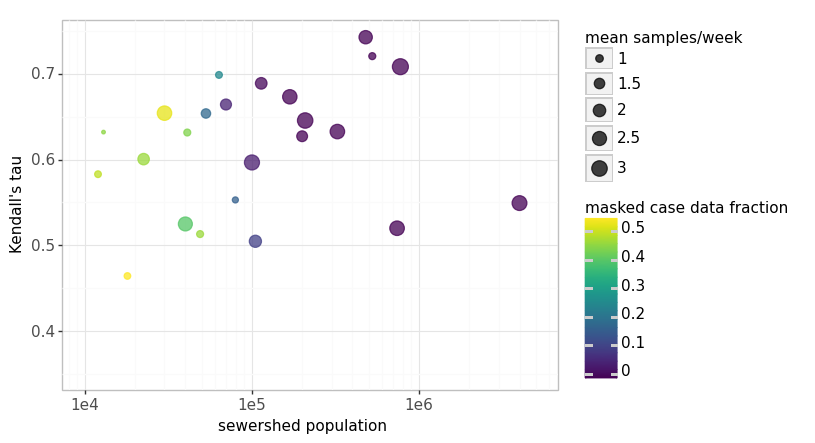

<ggplot: (8733561205117)>

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


In [225]:
metadata_selection = pd.read_excel(metadata_path)

metadata_selection = metadata_selection[['sample_code','site_population_served','adjusted_flow_corr','n_sample_size','mean_sampling_freq','fraction_masked']]
metadata_selection.site_population_served = metadata_selection.site_population_served

metadata_selection.rename(columns={'n_sample_size':'total number of samples',
                                   'mean_sampling_freq':'mean samples/week',
                                  #  'masking':'masked data fraction',
                                   'fraction_masked':'masked case data fraction',
                                   'site_population_served':'sewershed population'},inplace=True)

plt = (ggplot(metadata_selection, aes(x='sewershed population', y='adjusted_flow_corr', size='mean samples/week',color='masked case data fraction'))+
      geom_point(alpha=0.75)+
      scale_x_log10(limits=[10000,5000000])+
      theme_bw()+
      theme(panel_border=element_rect(fill='None', color='#BFBFBF'))+
      theme(text=element_text(size=11,family='sans-serif'))+
      ylab('Kendall\'s tau'))
display(plt)

ggsave(plt, fig1_path, verbose=False)

### Correlation with testing bias compensated cases

In [226]:
# Merge metadata onto corr_df
metadata = all[['sample_code','county']].drop_duplicates()
corr_df = pd.DataFrame(columns=['sample_code','no_adjustment_corr','no_adjustment_p','PMMoV_corr','PMMoV_p','adjusted_flow_corr','adjusted_flow_p','adjusted_rain_corr','adjusted_rain_p','corr_method'])
corr_df = corr_df.merge(metadata,how='left',on='sample_code')

corr_df = pd.DataFrame(columns=['sample_code','no_adjustment_corr','no_adjustment_p','PMMoV_corr','PMMoV_p',
                                'adjusted_flow_corr','adjusted_flow_p','adjusted_rain_corr','adjusted_rain_p','corr_method'])
for sample_code in all.sample_code.unique():
  corr = all[all.sample_code==sample_code][['gmean_value','gmean_PMMoV','adjusted_gmean_flow',
                                            'adjusted_gmean_rain','cases','county','date_sampling',
                                            'total_tests_by_pop_rolling_avg']]

  corr.date_sampling = corr.date_sampling.astype('datetime64[ns]')
  corr['positivity'] = corr.cases / corr.total_tests_by_pop_rolling_avg
  # Bias adjustment --> new case values
  corr.cases = corr.positivity / np.power(corr.total_tests_by_pop_rolling_avg,-0.5) * 100

  corr = corr[['gmean_value','gmean_PMMoV','adjusted_gmean_flow','adjusted_gmean_rain','cases']]
  x = corr.cases.copy()
  for method in ['kendall']:
    line = [sample_code]
    for column in corr.columns:
      if column != 'cases': # skip correlation with itself
        # Get rid of nans
        nan_df=pd.DataFrame()
        nan_df['x'] = np.log10(x)
        nan_df['y'] = np.log10(corr.loc[:,column])
        nan_df.replace(np.inf,np.nan,inplace=True)
        nan_df.replace(-np.inf,np.nan,inplace=True)
        nan_df.dropna(inplace=True)
        if method == 'pearson':
          # Calculate Pearson's r and p
          try:
            r, p = stats.pearsonr(nan_df.x,nan_df.y)
          except:
            r, p = np.nan, np.nan
        else:
          try:
            r, p = stats.kendalltau(nan_df.x,nan_df.y)
          except:
            r, p = np.nan, np.nan
        line.append(r)
        line.append(p)
        if p > 0.05:
          print('Correlation not stat. significant for: ',sample_code,' ',column,' method: ',method)
    line.append(method)
    corr_df.loc[len(corr_df)] = line

# Merge metadata onto corr_df
metadata = all[['sample_code','n_data_points_rolling_ave','county','sample_level','site_population_served']].drop_duplicates()
corr_df = corr_df.merge(metadata,how='left',on='sample_code')
print(corr_df.head(1))

corr_df.to_excel(bias_comp_corr_path,index=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


Correlation not stat. significant for:  A   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  B1   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  B2   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  B3   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  C1   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  D1   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  D2   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  D3   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  D4   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  F   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  G   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  I   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  K   gmean_PMMoV  method:  kendall
Correlation not stat. signific

### Correlation with non-bias testing compensation

In [227]:
# Merge metadata onto corr_df
metadata = all[['sample_code','county']].drop_duplicates()
corr_df = pd.DataFrame(columns=['sample_code','no_adjustment_corr','no_adjustment_p','PMMoV_corr','PMMoV_p','adjusted_flow_corr','adjusted_flow_p','adjusted_rain_corr','adjusted_rain_p','corr_method'])
corr_df = corr_df.merge(metadata,how='left',on='sample_code')

corr_df = pd.DataFrame(columns=['sample_code','no_adjustment_corr','no_adjustment_p','PMMoV_corr','PMMoV_p',
                                'adjusted_flow_corr','adjusted_flow_p','adjusted_rain_corr','adjusted_rain_p','corr_method'])
for sample_code in all.sample_code.unique():
  corr = all[all.sample_code==sample_code][['gmean_value','gmean_PMMoV','adjusted_gmean_flow',
                                              'adjusted_gmean_rain','cases','county','date_sampling','total_tests_by_pop_rolling_avg']]
  county = corr.county.iloc[0]
  corr.date_sampling = corr.date_sampling.astype('datetime64[ns]')
  corr.cases = corr.cases / (corr.total_tests_by_pop_rolling_avg / corr.total_tests_by_pop_rolling_avg.max())

  corr = corr[['gmean_value','gmean_PMMoV','adjusted_gmean_flow','adjusted_gmean_rain','cases']]
  x = corr.cases.copy()
  for method in ['kendall']:
    line = [sample_code]
    for column in corr.columns:
      if column != 'cases': # skip correlation with itself
        # Get rid of nans
        nan_df=pd.DataFrame()
        nan_df['x'] = np.log10(x)
        nan_df['y'] = np.log10(corr.loc[:,column])
        nan_df.replace(np.inf,np.nan,inplace=True)
        nan_df.replace(-np.inf,np.nan,inplace=True)
        nan_df.dropna(inplace=True)
        if method == 'pearson':
          # Calculate Pearson's r and p
          try:
            r, p = stats.pearsonr(nan_df.x,nan_df.y)
          except:
            r, p = np.nan, np.nan
        else:
          try:
            r, p = stats.kendalltau(nan_df.x,nan_df.y)
          except:
            r, p = np.nan, np.nan
        line.append(r)
        line.append(p)
        if p > 0.05:
          print('Correlation not stat. significant for: ',sample_code,' ',column,' method: ',method)
    line.append(method)
    corr_df.loc[len(corr_df)] = line
print(corr_df.head(3))

# Merge metadata onto corr_df
metadata = all[['sample_code','n_data_points_rolling_ave','county','sample_level','site_population_served']].drop_duplicates()
corr_df = corr_df.merge(metadata,how='left',on='sample_code')
print(corr_df.head(1))

corr_df.to_excel(capacity_comp_corr_path,index=False)

Correlation not stat. significant for:  A   gmean_value  method:  kendall
Correlation not stat. significant for:  A   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  A   adjusted_gmean_flow  method:  kendall
Correlation not stat. significant for:  A   adjusted_gmean_rain  method:  kendall
Correlation not stat. significant for:  B1   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  B2   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  B3   gmean_PMMoV  method:  kendall


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


Correlation not stat. significant for:  C1   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  D1   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  D3   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  D4   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  F   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  G   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  I   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  K   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  N   gmean_value  method:  kendall
Correlation not stat. significant for:  N   adjusted_gmean_flow  method:  kendall
Correlation not stat. significant for:  N   adjusted_gmean_rain  method:  kendall
Correlation not stat. significant for:  O   gmean_PMMoV  method:  kendall
Correlation not stat. significant for:  R   gmean_PMMoV  method:  kendall
Correlation not st

### Correlation with time shift

Calculate shifted correlations

In [ ]:
do = True
if do == True:

  for variant in ['pre_delta','delta','omicron_BA1','all']:
    display(variant)
    cases_long = cases_long.loc[~cases_long.sample_code.isin(['A','N'])]
    
    cases_long.date_sampling = pd.to_datetime(cases_long.date_sampling)
    cases_long_variant = cases_long.loc[(cases_long.date_sampling >= variant_timeframes.loc[variant,'start'])&
                                        (cases_long.date_sampling <= variant_timeframes.loc[variant,'end'])].copy()
    display(variant_timeframes.loc[variant,'start'])
    display(variant_timeframes.loc[variant,'end'])

    corr_df = pd.DataFrame(columns=['sample_code','g_no_adjustment_corr','g_no_adjustment_p','g_PMMoV_corr','g_PMMoV_p',
                                    'g_flow_adjusted_corr','g_flow_adjusted_p','g_rain_adjusted_corr','g_rain_adjusted_p',
                                    'adjusted_gmean_flow_lowess_corr','adjusted_gmean_flow_lowess_p',
                                    'cases_corr','cases_p','method','time_shift'])
    shifts = np.arange(-14,15) # creates [-14,...,+14]

    for sample_code in cases_long_variant.sample_code.unique():
      display(sample_code)
      for shift in shifts:
        corr = all.loc[all.sample_code==sample_code][['date_sampling','gmean_value','gmean_PMMoV',
                                                  'adjusted_gmean_flow','adjusted_gmean_rain','adjusted_gmean_flow_lowess','cases']].copy()
        corr.dropna(subset=['cases'],inplace=True)
        # Shift date but save original date
        dates = pd.DataFrame()
        # new date_sampling is calculated from original date - shift 
        # positive shift value represents a wastewater lead, negative shift value represents a wastewater lag
        dates['date_sampling'] = pd.to_datetime(corr.date_sampling) - datetime.timedelta(days=int(shift)) # move case data backward by n = shift
        dates['date_sampling_orig'] = corr.date_sampling
        dates['sample_code'] = sample_code
        cases = cases_long_variant[['date_sampling','sample_code','value']].copy()
        cases.date_sampling = cases.date_sampling.astype('datetime64[ns]')
        cases = pd.merge(left=dates, right=cases, how='left', on=['date_sampling','sample_code'])
        cases.dropna(subset=['value'],inplace=True)
        cases.rename(columns={'value':'shifted_value'},inplace=True)
        cases.drop(columns=['date_sampling'],inplace=True)
        # cases format: 'date_sampling_orig','sample_code','shifted_cases'
        # Assign shifted case data to original date in corr dataframe (shift will be saved below)
        corr = corr.merge(cases,left_on='date_sampling',right_on='date_sampling_orig',how='left')
        corr.drop(columns=['date_sampling_orig'],inplace=True)
        corr.dropna(subset=['shifted_value'],inplace=True)
        # Get correlation of shifted case data with g values
        x = corr.shifted_value.copy()
        for correlation_method in ['kendall']:
          line = [sample_code]
          for column in ['gmean_value','gmean_PMMoV','adjusted_gmean_flow','adjusted_gmean_rain','adjusted_gmean_flow_lowess','cases']:
            # Get rid of nans
            nan_df=pd.DataFrame()
            nan_df['x'] = x
            nan_df['y'] = corr.loc[:,column]
            nan_df = nan_df.loc[(nan_df.x > 0)&(nan_df.y > 0)].copy() # log not defined
            nan_df.dropna(inplace=True)
            if nan_df.empty == False:
              nan_df.x = np.log10(nan_df.x)
              nan_df.y = np.log10(nan_df.y)
              nan_df.replace(np.inf,np.nan,inplace=True)
              nan_df.replace(-np.inf,np.nan,inplace=True)
              nan_df.dropna(inplace=True)
              if correlation_method == 'pearson':
                try:
                  # Calculate Pearson's r and p
                  r, p = stats.pearsonr(nan_df.x,nan_df.y)
                except:
                  r, p = [np.nan,np.nan]
              else:
                try:
                  r, p = stats.kendalltau(nan_df.x,nan_df.y)
                except:
                  r, p = [np.nan,np.nan]
            else:
              r, p = [np.nan,np.nan]
            line.append(r)
            line.append(p)
          line.append(correlation_method)
          line.append(shift)
          corr_df.loc[len(corr_df)] = line

    corr_df.to_excel(shifted_corr_path + str(variant) + str(shift) + '.xlsx',index=False)

### Figure S1. Heatmap of shifted correlations

pre_delta
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr


/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 6 rows containing missing values.


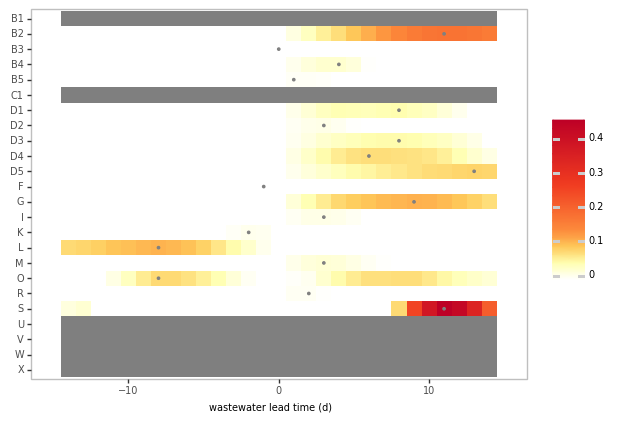

<ggplot: (8733560246497)>

'/content/gdrive/My Drive/WBE_UCB_Rebecca/Kara + Rebecca + Rose/Paper/Files/Analysis/Lowess/Figure S1_pre_delta_heatmap.png'

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 6 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_text : Removed 6 rows containing missing values.


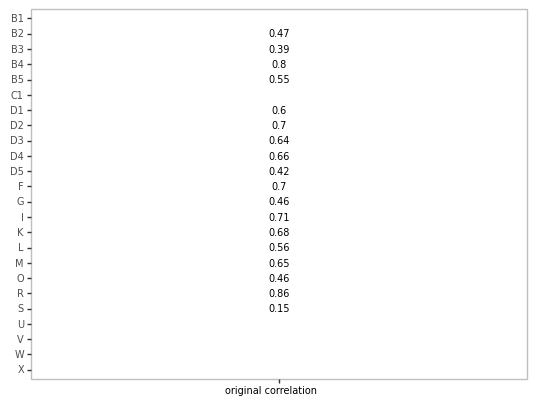

<ggplot: (8733562409673)>

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_text : Removed 6 rows containing missing values.


delta


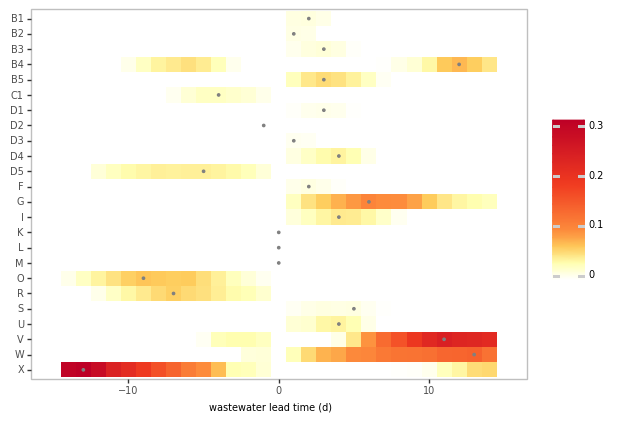

<ggplot: (8733560974957)>

'/content/gdrive/My Drive/WBE_UCB_Rebecca/Kara + Rebecca + Rose/Paper/Files/Analysis/Lowess/Figure S1_delta_heatmap.png'

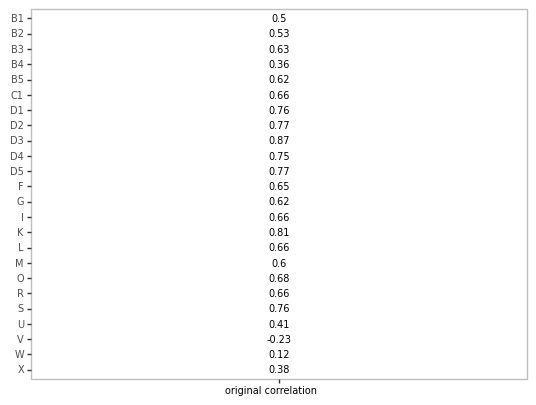

<ggplot: (8733559662173)>

omicron_BA1
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr
no max corr


/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 11 rows containing missing values.


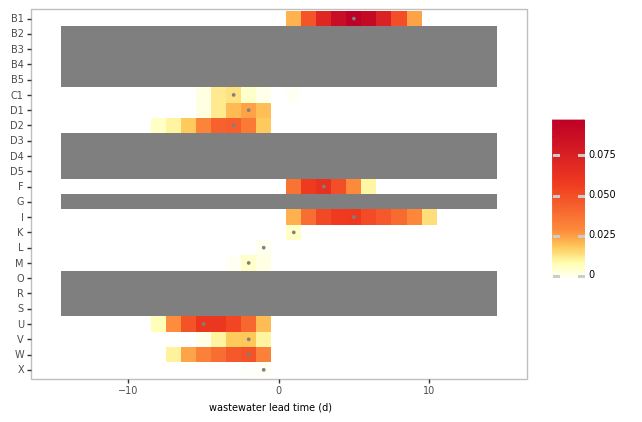

<ggplot: (8733559786465)>

'/content/gdrive/My Drive/WBE_UCB_Rebecca/Kara + Rebecca + Rose/Paper/Files/Analysis/Lowess/Figure S1_omicron_BA1_heatmap.png'

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 11 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_text : Removed 11 rows containing missing values.


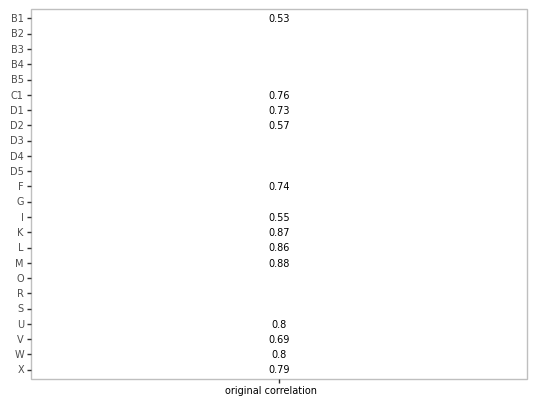

<ggplot: (8733560297241)>

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_text : Removed 11 rows containing missing values.


In [229]:
do = True
if do == True:
  for variant in ['pre_delta','delta','omicron_BA1']:
    print(variant)

    corr_df = pd.read_excel(shifted_corr_path + str(variant) + '14.xlsx')
    corr_df = corr_df[['sample_code','adjusted_gmean_flow_lowess_corr','time_shift']]

    # relative change from time shift 0
    rel_corr_df_full = pd.DataFrame(columns=['sample_code','corr_diff','time_shift'])
    sample_codes = corr_df.sample_code.unique()
    max_time_shift = pd.DataFrame(index=sample_codes,columns=['max_corr_shift','sample_code'])
    for sample_code in sample_codes:
      # Convert to relative
      rel_corr_df = corr_df.loc[(corr_df.sample_code == sample_code)][['sample_code','adjusted_gmean_flow_lowess_corr','time_shift']].copy() # select for site
      day0 = rel_corr_df.loc[rel_corr_df.time_shift == 0,'adjusted_gmean_flow_lowess_corr'].values # read original flow-adj. correlation
      rel_corr_df['corr_diff'] = rel_corr_df.adjusted_gmean_flow_lowess_corr - day0 # save difference between all correlations to pre-shift
      rel_corr_df = rel_corr_df[['sample_code','corr_diff','time_shift']] # save only difference to full df
      rel_corr_df_full = pd.concat([rel_corr_df_full,rel_corr_df])
      

    sample_codes = rel_corr_df_full.sample_code.unique()
    for sample_code in sample_codes:
      # Get df with max corr_diff shift for plot
      rel_corr_df = rel_corr_df_full.loc[rel_corr_df_full.sample_code == sample_code][['sample_code','corr_diff','time_shift']].copy()
      max_corr = rel_corr_df.corr_diff.max()
      try:
        max_time_shift.loc[sample_code,'max_corr_shift'] = rel_corr_df.loc[(rel_corr_df.corr_diff == max_corr), 'time_shift'].values[0]
      except:
        print('no max corr')
        max_corr = rel_corr_df.corr_diff.max()
        try:
          max_time_shift.loc[sample_code,'max_corr_shift'] = rel_corr_df.loc[(rel_corr_df.corr_diff == max_corr), 'time_shift'].values[0]
        except:
          print('no max corr')

    max_time_shift.reset_index(inplace=True,drop=False)
    max_time_shift.drop(columns=['sample_code'],inplace=True)
    max_time_shift.rename(columns={'index':'sample_code'},inplace=True)
    max_time_shift.max_corr_shift = max_time_shift.max_corr_shift.astype('float')

    rel_corr_df_full = rel_corr_df_full.merge(max_time_shift,on='sample_code',how='left')
    rel_corr_df_full = rel_corr_df_full.sort_values(by='sample_code',ascending=False).reset_index(drop = True)
    sample_code_categories = pd.unique(rel_corr_df_full.sample_code)
    rel_corr_df_full.sample_code = pd.Categorical(rel_corr_df_full.sample_code, categories=sample_code_categories)
    rel_corr_df_full.drop(columns=['max_corr_shift'],inplace=True)
      
    max_time_shift.max_corr_shift = max_time_shift.max_corr_shift.astype('float')
    rel_corr_df_full.time_shift = rel_corr_df_full.time_shift.astype('float')

    plt = (ggplot(rel_corr_df_full,aes(x='time_shift',y='sample_code',fill='corr_diff'))+
          geom_tile()+
          scale_fill_gradientn(colors=['#ffffff','#ffffb2','#fecc5c','#fd8d3c','#f03b20','#bd0026'],
                            values=[0,0.1,0.2,0.3,0.6,1],limits=[0,rel_corr_df_full.corr_diff.max()])+
          xlim(-15,15)+
          theme_bw()+
          annotate(geom='point',x=max_time_shift.max_corr_shift,y=max_time_shift.sample_code,color='gray',size=0.5)+
          guides(fill = guide_colourbar(title = ''))+
          labs(x='wastewater lead time (d)',y=None)+ 
          theme(legend_position = 'right',
                  plot_title = element_text(size=7),
                  axis_text_y = element_text(size=7),
                  panel_grid_major = element_blank(),
                  panel_grid_minor = element_blank(),
                  panel_border = element_rect(fill='None', color='#BFBFBF'),
                  text = element_text(size=7,family='sans-serif')))

    display(plt)

    figS1_full_path = figS1_path + str(variant) + '_heatmap.png'
    display(figS1_full_path)
    ggsave(plt, figS1_full_path,
              width = 8,
              height = 8,
              units = 'cm',
              verbose=False)

    corr_df = corr_df.loc[(corr_df.time_shift == 0)][['sample_code','time_shift','adjusted_gmean_flow_lowess_corr']]
    corr_df.adjusted_gmean_flow_lowess_corr = round(corr_df.adjusted_gmean_flow_lowess_corr,2)
    corr_df.time_shift = corr_df.time_shift.astype('int')
    corr_df.time_shift = corr_df.time_shift.astype('string')

    corr_df.sample_code = pd.Categorical(corr_df.sample_code, categories = sample_code_categories)
    corr_df.sort_values(by = 'sample_code')

    plt = (ggplot(corr_df)+
          geom_text(aes(x='time_shift',y='sample_code',label ='adjusted_gmean_flow_lowess_corr'),size=7,color='black')+
          theme_bw()+
          labs(x='original correlation',y=None)+ 
          theme(legend_position = 'right',
                  plot_title = element_text(size=7),
                  axis_text_y = element_text(size=7),
                  axis_text_x = element_blank(),
                  panel_grid_major = element_blank(),
                  panel_grid_minor = element_blank(),
                  panel_border = element_rect(fill='None', color='#BFBFBF'),
                  text = element_text(size=7,family='sans-serif')))

    display(plt)
    ggsave(plt, figS1_path + str(variant) + '_correlation.png',
              width = 2,
              height = 8,
              units = 'cm',
              verbose=False)
    del rel_corr_df_full, max_time_shift


all


0.033384732617926294

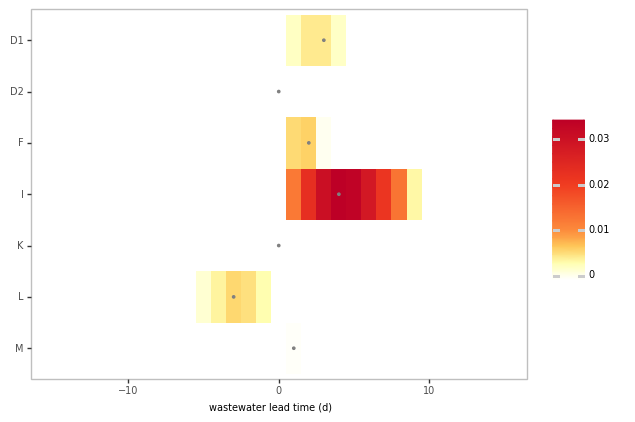

<ggplot: (8733560971681)>

'/content/gdrive/My Drive/WBE_UCB_Rebecca/Kara + Rebecca + Rose/Paper/Files/Analysis/Lowess/Figure S1_all_heatmap.png'

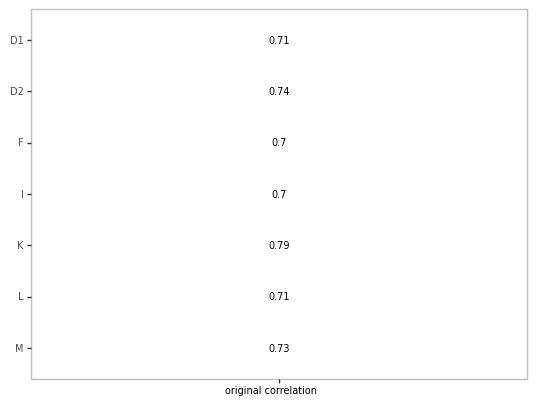

<ggplot: (8733562477725)>

In [230]:
do = True
if do == True:
  for variant in ['all']:
    print(variant)

    corr_df = pd.read_excel(shifted_corr_path + str(variant) + '14.xlsx')
    corr_df = corr_df[['sample_code','adjusted_gmean_flow_lowess_corr','time_shift']]
    corr_df = corr_df.loc[corr_df.sample_code.isin(['D1','D2','F','I','K','L','M'])]
    
    # relative change from time shift 0
    rel_corr_df_full = pd.DataFrame(columns=['sample_code','corr_diff','time_shift'])
    max_time_shift = pd.DataFrame(index=['D1','D2','F','I','K','L','M'],columns=['max_corr_shift','sample_code'])
    for sample_code in ['D1','D2','F','I','K','L','M']:
      # Convert to relative
      rel_corr_df = corr_df.loc[(corr_df.sample_code == sample_code)][['sample_code','adjusted_gmean_flow_lowess_corr','time_shift']].copy() # select for site
      day0 = rel_corr_df.loc[rel_corr_df.time_shift == 0,'adjusted_gmean_flow_lowess_corr'].values # read original flow-adj. correlation
      rel_corr_df['corr_diff'] = rel_corr_df.adjusted_gmean_flow_lowess_corr - day0 # save difference between all correlations to pre-shift
      rel_corr_df = rel_corr_df[['sample_code','corr_diff','time_shift']] # save only difference to full df
      rel_corr_df_full = pd.concat([rel_corr_df_full,rel_corr_df])
      
    for sample_code in ['D1','D2','F','I','K','L','M']:
      # Get df with max corr_diff shift for plot
      rel_corr_df = rel_corr_df_full.loc[rel_corr_df_full.sample_code == sample_code][['sample_code','corr_diff','time_shift']].copy()
      max_corr = rel_corr_df.corr_diff.max()
      try:
        max_time_shift.loc[sample_code,'max_corr_shift'] = rel_corr_df.loc[(rel_corr_df.corr_diff == max_corr), 'time_shift'].values[0]
      except:
        print('no max corr')
        max_corr = rel_corr_df.corr_diff.max()
        try:
          max_time_shift.loc[sample_code,'max_corr_shift'] = rel_corr_df.loc[(rel_corr_df.corr_diff == max_corr), 'time_shift'].values[0]
        except:
          print('no max corr')

    max_time_shift.reset_index(inplace=True,drop=False)
    max_time_shift.drop(columns=['sample_code'],inplace=True)
    max_time_shift.rename(columns={'index':'sample_code'},inplace=True)
    max_time_shift.max_corr_shift = max_time_shift.max_corr_shift.astype('float')

    rel_corr_df_full = rel_corr_df_full.sort_values(by='sample_code',ascending=False).reset_index(drop = True)
    sample_code_categories = pd.unique(rel_corr_df_full.sample_code)
    rel_corr_df_full.sample_code = pd.Categorical(rel_corr_df_full.sample_code, categories=sample_code_categories)
    
    max_time_shift.max_corr_shift = max_time_shift.max_corr_shift.astype('float')
    rel_corr_df_full.time_shift = rel_corr_df_full.time_shift.astype('float')
    display(rel_corr_df_full.corr_diff.max())

    plt = (ggplot(rel_corr_df_full,aes(x='time_shift',y='sample_code',fill='corr_diff'))+
          geom_tile()+
          scale_fill_gradientn(colors=['#ffffff','#ffffb2','#fecc5c','#fd8d3c','#f03b20','#bd0026'],
                            values=[0,0.1,0.2,0.3,0.6,1],limits=[0,rel_corr_df_full.corr_diff.max()])+
          xlim(-15,15)+
          theme_bw()+
          annotate(geom='point',x=max_time_shift.max_corr_shift,y=max_time_shift.sample_code,color='gray',size=0.5)+
          guides(fill = guide_colourbar(title = ''))+
          labs(x='wastewater lead time (d)',y=None)+ 
          theme(legend_position = 'right',
                  plot_title = element_text(size=7),
                  axis_text_y = element_text(size=7),
                  panel_grid_major = element_blank(),
                  panel_grid_minor = element_blank(),
                  panel_border = element_rect(fill='None', color='#BFBFBF'),
                  text = element_text(size=7,family='sans-serif')))

    display(plt)

    figS1_full_path = figS1_path + str(variant) + '_heatmap.png'
    display(figS1_full_path)
    ggsave(plt, figS1_full_path,
              width = 8,
              height = 8,
              units = 'cm',
              verbose=False)

    corr_df = corr_df.loc[(corr_df.time_shift == 0)][['sample_code','time_shift','adjusted_gmean_flow_lowess_corr']]
    corr_df.adjusted_gmean_flow_lowess_corr = round(corr_df.adjusted_gmean_flow_lowess_corr,2)
    corr_df.time_shift = corr_df.time_shift.astype('int')
    corr_df.time_shift = corr_df.time_shift.astype('string')

    corr_df.sample_code = pd.Categorical(corr_df.sample_code, categories = sample_code_categories)
    corr_df.sort_values(by = 'sample_code')

    plt = (ggplot(corr_df)+
          geom_text(aes(x='time_shift',y='sample_code',label ='adjusted_gmean_flow_lowess_corr'),size=7,color='black')+
          theme_bw()+
          labs(x='original correlation',y=None)+ 
          theme(legend_position = 'right',
                  plot_title = element_text(size=7),
                  axis_text_y = element_text(size=7),
                  axis_text_x = element_blank(),
                  panel_grid_major = element_blank(),
                  panel_grid_minor = element_blank(),
                  panel_border = element_rect(fill='None', color='#BFBFBF'),
                  text = element_text(size=7,family='sans-serif')))

    display(plt)
    ggsave(plt, figS1_path + str(variant) + '_correlation.png',
              width = 2,
              height = 8,
              units = 'cm',
              verbose=False)
    del rel_corr_df_full, max_time_shift

# Log ratio analysis

## Figure S2. Plot log-log ratio over time for each sewershed paired with log-scale ww & case data

Get log values

In [231]:
all['log_gmean'] = np.log10(all.adjusted_gmean_flow)
all['log_gmean_lowess'] = np.log10(all.adjusted_gmean_flow_lowess)
all['log_cases'] = np.log10(all.cases)
all['log_cases_to_log_gmean'] = all.log_cases / all.log_gmean
all['log_cases_to_log_gmean_lowess'] = all.log_cases / all.log_gmean_lowess

all.replace(np.inf,np.nan,inplace=True)
all.replace(-np.inf,np.nan,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


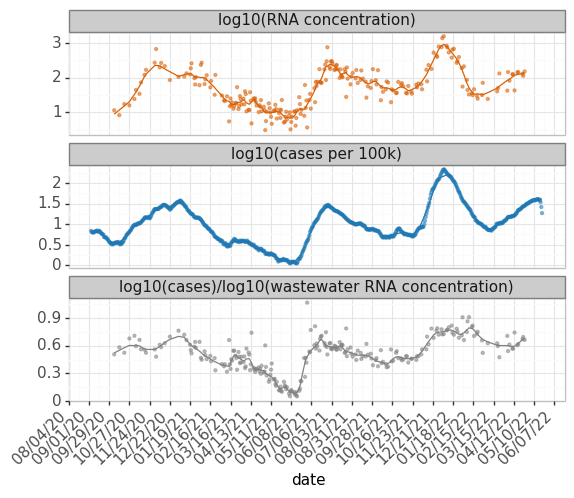

<ggplot: (8733561513709)>

/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


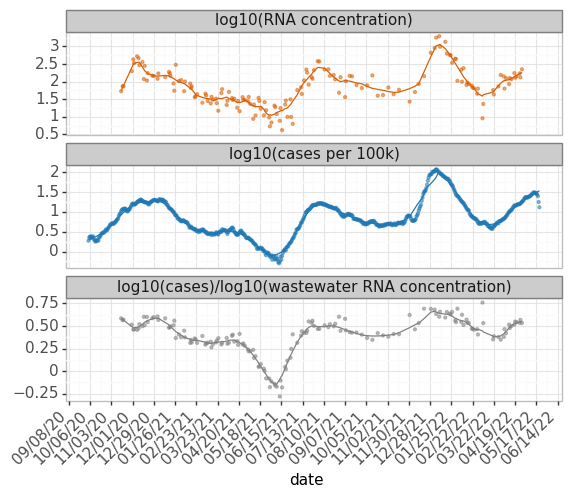

<ggplot: (8733560182141)>

/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


In [232]:
log_log_plt = all[['sample_code','date_sampling','log_cases','log_gmean','log_cases_to_log_gmean','cases','adjusted_gmean_flow']].copy()
log_log_plt.rename(columns={'date_sampling':'date',
                            'log_cases_to_log_gmean':'log10(cases)/log10(wastewater RNA concentration)',
                            'cases':'cases per 100k',
                            'log_cases':'log10(cases per 100k)',
                            'adjusted_gmean_flow':'RNA concentration',
                            'log_gmean':'log10(RNA concentration)'
                            },inplace=True)

log_log_plt.loc[:,'log10(cases per 100k)'] = log_log_plt.loc[:,'log10(cases per 100k)'].astype('float')
log_log_plt.loc[:,'log10(RNA concentration)'] = log_log_plt.loc[:,'log10(RNA concentration)'].astype('float')

log_log_plt = log_log_plt.melt(id_vars=['sample_code','date'],value_vars=['log10(cases per 100k)','log10(RNA concentration)','log10(cases)/log10(wastewater RNA concentration)'])
log_log_plt.dropna(subset=['value'],inplace=True)

colors = {'log10(cases per 100k)':'#1f78b4', 'log10(RNA concentration)':'#d95f02','log10(cases)/log10(wastewater RNA concentration)':'gray'} 

log_log_plt.date = log_log_plt.date.astype('datetime64[ns]')

sample_codes = log_log_plt.sample_code.unique()
for code in ['D1','K']:
  log_log_code = log_log_plt.loc[log_log_plt.sample_code == code]
  alpha = 10 / log_log_code.loc[log_log_code.variable == 'log10(RNA concentration)','value'].count()
  plt = (ggplot(log_log_code, aes(x='date', y='value', group='variable',color='variable'))+
        geom_point(size=0.75, alpha=0.5)+
        stat_smooth(method='lowess',span=alpha,size=0.5)+
        scale_color_manual(values=colors)+
        ylab('')+
        scale_x_datetime(breaks = '4 week', labels = date_format('%D'))+
        theme(axis_text_x=element_text(rotation=45, hjust=1))+
        theme_bw()+
        theme(panel_border=element_rect(fill='None', color='#BFBFBF'))+
        theme(text=element_text(size=11,family='sans-serif'))+
        facet_wrap('~ variable',ncol=1,scales='free_y')+
        theme(axis_text_x=element_text(rotation=45, hjust=1))+
        theme(legend_position = 'none'))
  display(plt)
        
  ggsave(plt, figS2_path + str(code) + '.png',
        verbose=False)

## Ratio analysis throughout variants and sewersheds

Further processing (add ratio of log(gmean) to log(cases))

In [233]:
## Calculate log(cases), log(gmean)
log_log = all[['sample_code','date_sampling','log_cases','log_gmean_lowess','log_cases_to_log_gmean_lowess']].copy()

Get min/max/min for D1, D2, K, L, M for each surge

In [234]:
log_log_ex = log_log.loc[log_log.sample_code.isin(['D1','D2','K','L','M'])][['sample_code','date_sampling','log_cases','log_gmean_lowess']].copy()
print(log_log_ex.sample_code.unique())

['D1' 'D2' 'K' 'L' 'M']


Calculate maxima

In [235]:
pre_delta = pd.DataFrame()
delta = pd.DataFrame()
omicron_BA1 = pd.DataFrame()

variant_names = ['pre_delta','delta','omicron_BA1']
variants = [pre_delta,delta,omicron_BA1]

pre_delta.name = 'pre_delta'
delta.name = 'delta'
omicron_BA1.name = 'omicron_BA1'

for code in log_log_ex.sample_code.unique():
  for variant in variants:
    log_log_ex_code = log_log_ex.loc[(log_log_ex.sample_code == code)&
                                     (log_log_ex.date_sampling >= variant_timeframes.loc[variant.name,'start'])&
                                     (log_log_ex.date_sampling <= variant_timeframes.loc[variant.name,'end'])]
    variant.loc[code,'max_log_cases'] = log_log_ex_code.log_cases.max()
    variant.loc[code,'max_log_gmean'] = log_log_ex_code.log_gmean_lowess.max()
    variant.loc[code,'max_log_ratio'] = variant.loc[code,'max_log_cases'] / variant.loc[code,'max_log_gmean']

print(variants)

[    max_log_cases  max_log_gmean  max_log_ratio
D1       1.572422       2.659245       0.591304
D2       1.470263       2.334497       0.629799
K        1.313139       2.674311       0.491020
L        2.044484       3.062791       0.667523
M        2.111208       3.054905       0.691088,     max_log_cases  max_log_gmean  max_log_ratio
D1       1.466633       2.864753       0.511958
D2       1.346330       2.601857       0.517450
K        1.214812       2.570309       0.472633
L        1.821888       2.815142       0.647174
M        1.719737       2.657462       0.647135,     max_log_cases  max_log_gmean  max_log_ratio
D1       2.328591       3.147563       0.739807
D2       2.378362       3.194675       0.744477
K        2.063834       3.166824       0.651705
L        2.485721       3.210476       0.774253
M        2.644459       3.279493       0.806362]


Compare maxima of all variants

In [236]:
# Kruskall-Wallis test
res = stats.kruskal(pre_delta.max_log_ratio,delta.max_log_ratio,omicron_BA1.max_log_ratio,nan_policy='omit')
print('Kruskall-Wallis: ',res)

Kruskall-Wallis:  KruskalResult(statistic=8.54, pvalue=0.013981783153338307)


Compare variants individually

In [237]:
# Mann-Whitney test
mann_whitney = pd.DataFrame(columns=variant_names,index=variant_names)
for variant1 in variants:
  for variant2 in variants:
    U, mann_whitney.loc[variant1.name,variant2.name] = stats.mannwhitneyu(variant1.max_log_ratio,variant2.max_log_ratio)

print(mann_whitney)
mann_whitney.to_csv(variant_maxima_path)

            pre_delta     delta omicron_BA1
pre_delta         1.0  0.420635    0.031746
delta        0.420635       1.0    0.007937
omicron_BA1  0.031746  0.007937         1.0


## Figure 4. Boxplot of differences between maxima of each variant

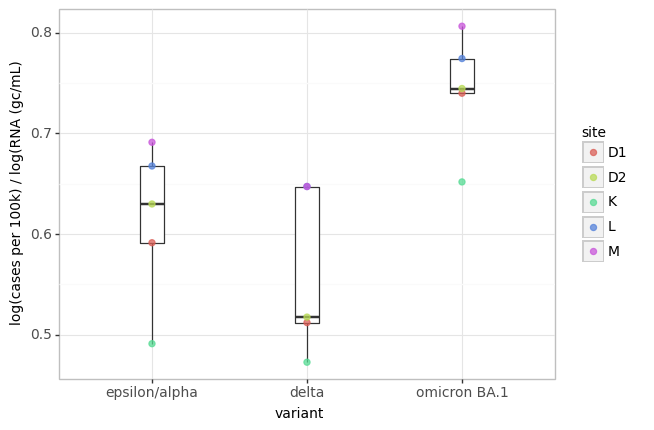

<ggplot: (8733560028261)>

In [238]:
for variant in variants:
  variant.loc[:,'variant'] = variant.name

variants_max_log_ratio = pd.concat(variants)
variants_max_log_ratio = variants_max_log_ratio.loc[variants_max_log_ratio.variant.isin(['pre_delta',
                                                                                         'delta',
                                                                                         'omicron_BA1'])][['max_log_ratio','variant']]

variants_max_log_ratio.replace({'pre_delta':'epsilon/alpha',
                                'omicron_BA1':'omicron BA.1'},inplace=True)

y_label_pos = variants_max_log_ratio.loc[:,'max_log_ratio'].max() * 1.1
alpha_epsilon_label = 'n = ' + str(5)
delta_label = 'n = ' + str(5)
omicron_label = 'n = ' + str(5)

variants_max_log_ratio.reset_index(inplace=True)
variants_max_log_ratio.rename(columns={'index':'site'},inplace=True)

plt = (ggplot(variants_max_log_ratio)+
          geom_boxplot(aes(x='variant', y='max_log_ratio'),width=0.15,outlier_alpha=0)+
          geom_jitter(aes(x='variant', y='max_log_ratio',color='site'),size=2,alpha=0.75,width=0)+
          ylab('log(cases per 100k) / log(RNA (gc/mL)')+
          scale_x_discrete(limits=['epsilon/alpha','delta','omicron BA.1'])+
          theme_bw()+
          theme(panel_border=element_rect(fill='None', color='#BFBFBF'))+
          theme(text=element_text(size=10,family='sans-serif')))
display(plt)

ggsave(plt,fig4_path,dpi=500,verbose=False)

Compare sites

In [239]:
# Mann-Whitney test
sites = ['D1','D2','K','L','M']
print(variants_max_log_ratio)
mann_whitney_sites = pd.DataFrame(columns=sites,index=sites)
for site1 in sites:
  for site2 in sites:
    U, mann_whitney_sites.loc[site1,site2] = stats.mannwhitneyu(variants_max_log_ratio.loc[variants_max_log_ratio.site == site1,'max_log_ratio'],
                                                          variants_max_log_ratio.loc[variants_max_log_ratio.site == site2,'max_log_ratio'])

print(mann_whitney_sites)

# Kruskall-Wallis test
res = stats.kruskal(variants_max_log_ratio.loc[variants_max_log_ratio.site == 'D1','max_log_ratio'],
                    variants_max_log_ratio.loc[variants_max_log_ratio.site == 'D2','max_log_ratio'],
                    variants_max_log_ratio.loc[variants_max_log_ratio.site == 'K','max_log_ratio'],
                    variants_max_log_ratio.loc[variants_max_log_ratio.site == 'L','max_log_ratio'],
                    variants_max_log_ratio.loc[variants_max_log_ratio.site == 'M','max_log_ratio'],
                    nan_policy='omit')
print('Kruskall-Wallis: ',res)

   site  max_log_ratio        variant
0    D1       0.591304  epsilon/alpha
1    D2       0.629799  epsilon/alpha
2     K       0.491020  epsilon/alpha
3     L       0.667523  epsilon/alpha
4     M       0.691088  epsilon/alpha
5    D1       0.511958          delta
6    D2       0.517450          delta
7     K       0.472633          delta
8     L       0.647174          delta
9     M       0.647135          delta
10   D1       0.739807   omicron BA.1
11   D2       0.744477   omicron BA.1
12    K       0.651705   omicron BA.1
13    L       0.774253   omicron BA.1
14    M       0.806362   omicron BA.1
     D1   D2    K    L    M
D1  1.0  0.7  0.4  0.4  0.4
D2  0.7  1.0  0.4  0.4  0.4
K   0.4  0.4  1.0  0.2  0.2
L   0.4  0.4  0.2  1.0  1.0
M   0.4  0.4  0.2  1.0  1.0
Kruskall-Wallis:  KruskalResult(statistic=5.100000000000001, pvalue=0.2771899143040935)


## Figure 2. Lag plot for D1 & K

In [ ]:
log_log_plt = all[['sample_code','date_sampling','log_cases_to_log_gmean',
                   'cases','adjusted_gmean_flow','adjusted_gmean_flow_lowess']].copy()

In [241]:
sites = ['D1','K']
wastewater_lead = pd.DataFrame(columns=['pre_delta','delta','omicron_BA1'],index=sites)
wastewater_lead_lowess = pd.DataFrame(columns=['pre_delta','delta','omicron_BA1'],index=sites)
max_gmean_date_lowess = pd.DataFrame(columns=['pre_delta','delta','omicron_BA1'],index=sites)
max_gmean_date = pd.DataFrame(columns=['pre_delta','delta','omicron_BA1'],index=sites)
max_cases_date = pd.DataFrame(columns=['pre_delta','delta','omicron_BA1'],index=sites)

# Calculate lag between maxima for D1 and K
for code in sites:
    log_log_code = log_log_plt.loc[log_log_plt.sample_code == code]
    for variant in ['pre_delta','delta','omicron_BA1']:
      log_log_code_variant = log_log_code.loc[(log_log_code.date_sampling >= variant_timeframes.loc[variant,'start'])&
                                              (log_log_code.date_sampling <= variant_timeframes.loc[variant,'end'])].copy()
      max_gmean_date_lowess.loc[code,variant] = log_log_code_variant.loc[(log_log_code_variant.adjusted_gmean_flow_lowess == log_log_code_variant.adjusted_gmean_flow_lowess.max()), 'date_sampling'].values[0]
      max_gmean_date.loc[code,variant] = log_log_code_variant.loc[(log_log_code_variant.adjusted_gmean_flow == log_log_code_variant.adjusted_gmean_flow.max()), 'date_sampling'].values[0]
      max_cases_date.loc[code,variant] = log_log_code_variant.loc[(log_log_code_variant.cases == log_log_code_variant.cases.max()), 'date_sampling'].values[0]
      wastewater_lead.loc[code,variant] = str(pd.to_timedelta((max_cases_date .loc[code,variant] - max_gmean_date.loc[code,variant]),unit='days').days) + ' days'
      wastewater_lead_lowess.loc[code,variant] = str(pd.to_timedelta((max_cases_date .loc[code,variant] - max_gmean_date_lowess.loc[code,variant]),unit='days').days) + ' days'


In [242]:
log_log_plt.rename(columns={'date_sampling':'date',
                            'log_cases_to_log_gmean':'log10(cases/RNA concentration)',
                            'cases':'cases per 100k',
                            'adjusted_gmean_flow':'RNA concentration'},inplace=True)

log_log_plt = log_log_plt.melt(id_vars=['sample_code','date'],value_vars=['cases per 100k','RNA concentration'])
log_log_plt.dropna(subset=['value'],inplace=True)

colors = {'cases per 100k':'#1f78b4', 'RNA concentration':'#d95f02', 'RNA concentration smoothed':'#d95f02','log10(cases/RNA concentration)':'gray'} 

log_log_plt.date = log_log_plt.date.astype('datetime64[ns]')
max_cases_date = max_cases_date.astype('datetime64[ns]')
max_gmean_date = max_gmean_date.astype('datetime64[ns]')
max_gmean_date_lowess = max_gmean_date_lowess.astype('datetime64[ns]')

/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


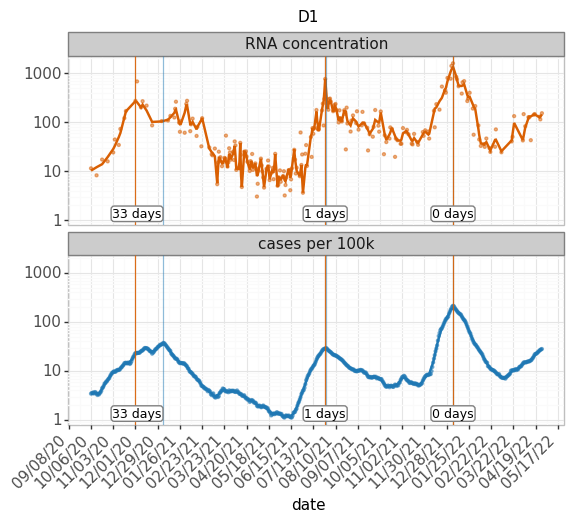

<ggplot: (8733559505589)>

/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


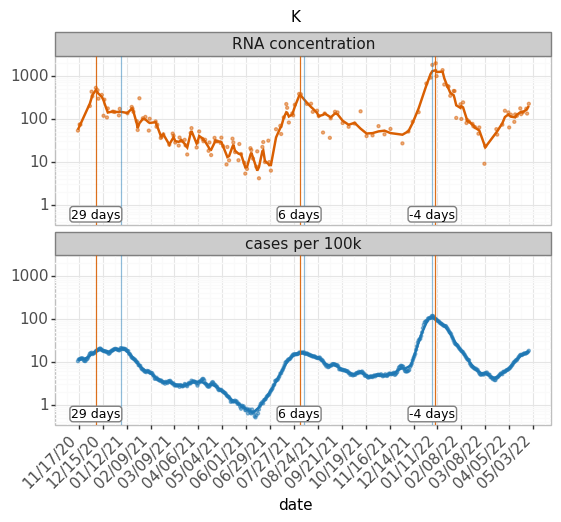

<ggplot: (8733561163797)>

/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


In [243]:
for code in sites:
  log_log_code = log_log_plt.loc[log_log_plt.sample_code == code]
  date_min = log_log_code.loc[log_log_code.variable == 'RNA concentration','date'].min()
  date_max = log_log_code.loc[log_log_code.variable == 'RNA concentration','date'].max()
  log_log_code = log_log_code.loc[(log_log_code.date <= date_max)&(log_log_code.date >= date_min)]
  span = 5 / log_log_code.loc[log_log_code.variable == 'RNA concentration','value'].count()

  x_intercepts_cases = max_cases_date.loc[code,:].to_list()
  x_intercepts_gmean = max_gmean_date.loc[code,:].to_list()
  x_intercepts_gmean_lowess = max_gmean_date_lowess.loc[code,:].to_list()

  label_xs = []
  for cases_date,gmean_date in zip(x_intercepts_cases,x_intercepts_gmean):
    minimum = min([cases_date,gmean_date])
    label_x = minimum# - pd.to_timedelta(14,unit='days')
    label_xs.append(label_x)
  
  label_ys = [(log_log_code.value.min()*1.2),(log_log_code.value.min()*1.2),(log_log_code.value.min()*1.2)]

  label_text = wastewater_lead.loc[code,:].astype(str).to_list()

  plt = (ggplot(log_log_code, aes(x='date', y='value', group='variable',color='variable'))+
        geom_point(size=0.75, alpha=0.5)+
        geom_smooth(span=span,method='lowess')+
        geom_vline(xintercept = x_intercepts_cases, color='#1f78b4', alpha=0.5)+
        geom_vline(xintercept = x_intercepts_gmean_lowess, color='#d95f02', alpha=0.9)+
        
        annotate('label', x=label_xs[0], y=label_ys[0], label=label_text[0], size=9, boxcolor='gray', label_size=1, label_padding = 0.1)+ 
        annotate('label', x=label_xs[1], y=label_ys[1], label=label_text[1], size=9, boxcolor='gray', label_size=1, label_padding = 0.1)+
        annotate('label', x=label_xs[2], y=label_ys[2], label=label_text[2], size=9, boxcolor='gray', label_size=1, label_padding = 0.1)+
        
        scale_color_manual(values=colors)+
        scale_y_log10()+
        ylab('')+
        scale_x_datetime(breaks = '4 week', labels = date_format('%D'))+
        theme(axis_text_x=element_text(rotation=45, hjust=1))+
        ggtitle(code)+
        theme_bw()+
        theme(panel_border=element_rect(fill='None', color='#BFBFBF'))+
        theme(text=element_text(size=11,family='sans-serif'))+
        facet_wrap('~ variable',ncol=1,scales='fixed')+
        theme(axis_text_x=element_text(rotation=45, hjust=1))+
        theme(legend_position = 'none',legend_box_spacing=.7)+
        theme(legend_title = None))
  display(plt)
        
  ggsave(plt, fig2_path + str(code) + '.png',
        verbose=False)

## Figure 3. Plot log-log ratio over time for all chosen sewersheds

875
871
0.5466087451738016


/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


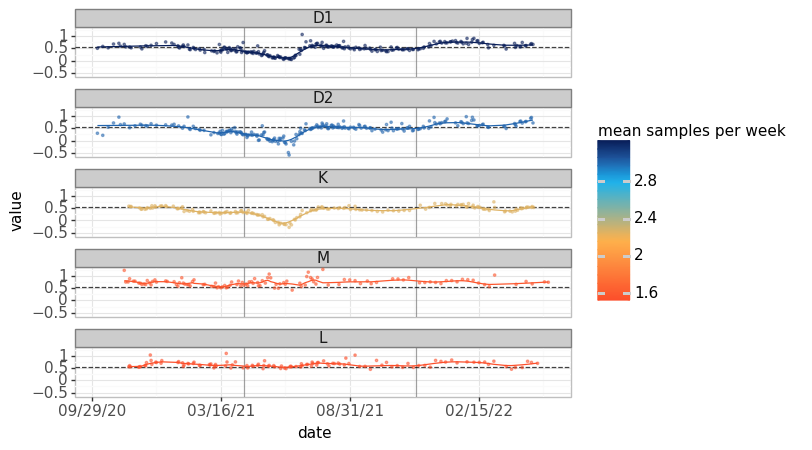

<ggplot: (8733562079001)>

/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


In [244]:
log_log_plt = all[['sample_code','date_sampling','log_cases_to_log_gmean','site_population_served']].copy()
log_log_plt.dropna(subset=['log_cases_to_log_gmean'],inplace=True)

metadata = pd.read_excel(metadata_path)
log_log_plt = log_log_plt.merge(metadata[['sample_code','mean_sampling_freq']],how='left',on='sample_code')
log_log_plt.rename(columns={'mean_sampling_freq':'mean samples per week',
                            'site_population_served':'population (thousands)',
                            'log_cases_to_log_gmean':'log10(cases/RNA concentration)',
                            'date_sampling':'date'},inplace=True)

log_log_plt = log_log_plt.loc[log_log_plt.sample_code.isin(['D1','D2','K','L','M'])]

# Remove two outliers for M
print(len(log_log_plt))
log_log_plt = log_log_plt.loc[log_log_plt.loc[:,'log10(cases/RNA concentration)']<2]
print(len(log_log_plt))

log_log_plt.loc[:,'population (thousands)'] = log_log_plt.loc[:,'population (thousands)'].astype('int') / 1000
log_log_plt = log_log_plt.melt(id_vars=['sample_code','date','population (thousands)','mean samples per week'],
                                value_vars=['log10(cases/RNA concentration)'])

log_log_plt.loc[:,'population (thousands)'] = log_log_plt.loc[:,'population (thousands)'].astype('int')


# sort by population
population_categorical = log_log_plt[['sample_code','mean samples per week']].drop_duplicates()
population_categorical = population_categorical.sort_values(by='mean samples per week',ascending=False)
categories = population_categorical.sample_code
log_log_plt.sample_code = pd.Categorical(log_log_plt.sample_code, categories = categories)
log_log_plt.sort_values(by = 'sample_code')


log_log_plt.date = log_log_plt.date.astype('datetime64[ns]')

log_log_plt.dropna(subset=['value'],inplace=True)
ratio_median = log_log_plt.value.median()
print(ratio_median)

plt = (ggplot(log_log_plt, aes(x='date', y='value', group='sample_code', color = 'mean samples per week'))+
      geom_vline(aes(xintercept=pd.to_datetime('2021-04-15')),color='gray',alpha=0.75)+
      geom_vline(aes(xintercept=pd.to_datetime('2021-11-26')),color='gray',alpha=0.75)+
      geom_hline(aes(yintercept=ratio_median),color='black',linetype='dashed',alpha=0.75,size=0.5)+
      geom_smooth(method='lowess',span=0.1,size=0.5)+
      geom_point(size=0.5,alpha=0.5)+
      scale_color_gradientn(colors=['#fc4e2a','#feb24c','#18b2f0','#225ea8','#081d58'],
      values=[0,0.375,0.75,0.875,1])+
      ylab('')+
      theme_bw()+
      theme(panel_border=element_rect(fill='None', color='#BFBFBF'))+
      theme(text=element_text(size=11,family='sans-serif'))+
      scale_x_datetime(breaks = '24 week', labels = date_format('%D'))+
      facet_wrap('~ sample_code',ncol=1))
display(plt)
      
ggsave(plt, fig3_path,
      width = 15,
      height = 15,
      units = 'cm',
      # dpi=500,
      verbose=False)


## Figure S3. All sites all surges (minus 1 outlier)

array(['A', 'B1**', 'B2***', 'B3***', 'B4***', 'B5***', 'C1', 'D1', 'D2',
       'D3', 'D4**', 'D5**', 'F***', 'G***', 'I**', 'K', 'L', 'M*', 'N',
       'O***', 'R*', 'S*', 'U', 'V***', 'W', 'X'], dtype=object)

2124
2123
0.6099175625114522


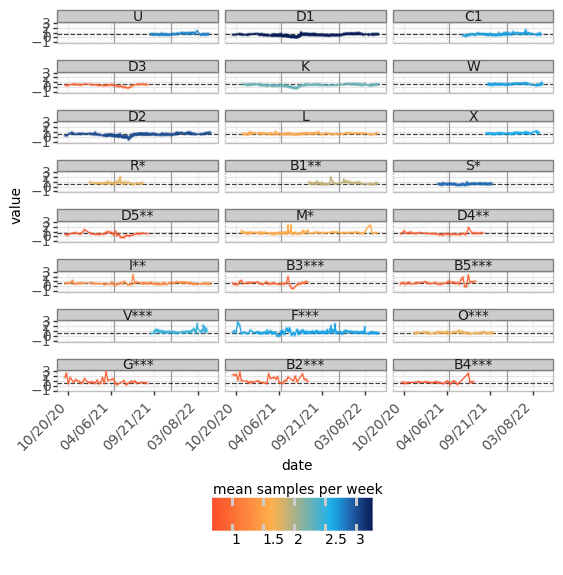

<ggplot: (8733560182033)>

In [280]:
log_log_plt = all[['sample_code','date_sampling','log_cases_to_log_gmean','site_population_served']].copy()
log_log_plt.dropna(subset=['log_cases_to_log_gmean'],inplace=True)

metadata = pd.read_excel(metadata_path)
log_log_plt = log_log_plt.merge(metadata[['sample_code','mean_sampling_freq']],how='left',on='sample_code')
log_log_plt.rename(columns={'mean_sampling_freq':'mean samples per week',
                            'site_population_served':'population (thousands)',
                            'log_cases_to_log_gmean':'log10(cases/RNA concentration)',
                            'date_sampling':'date'},inplace=True)

log_log_plt.replace({'R':'R*',
                      'B1':'B1**',
                      'S':'S*',
                      'D5':'D5**',
                      'M':'M*',
                      'D4':'D4**',
                      'I':'I**',
                      'B3':'B3***',
                      'B5':'B5***',
                      'V':'V***',
                      'F':'F***',
                      'O':'O***',
                      'G':'G***',
                      'B4':'B4***',
                      'B2':'B2***'},inplace=True)

display(log_log_plt.sample_code.unique())
log_log_plt = log_log_plt.loc[~log_log_plt.sample_code.isin(['A','N'])]

# Remove outliers?
print(len(log_log_plt))
log_log_plt = log_log_plt.loc[log_log_plt.loc[:,'log10(cases/RNA concentration)']<3.1]
print(len(log_log_plt))

log_log_plt.loc[:,'population (thousands)'] = log_log_plt.loc[:,'population (thousands)'].astype('int') / 1000
log_log_plt = log_log_plt.melt(id_vars=['sample_code','date','population (thousands)','mean samples per week'],
                                value_vars=['log10(cases/RNA concentration)'])

log_log_plt.loc[:,'population (thousands)'] = log_log_plt.loc[:,'population (thousands)'].astype('int')

# sort by population
population_categorical = log_log_plt[['sample_code','population (thousands)']].drop_duplicates()
population_categorical = population_categorical.sort_values(by='population (thousands)',ascending=False)
categories = population_categorical.sample_code
log_log_plt.sample_code = pd.Categorical(log_log_plt.sample_code, categories = categories)
log_log_plt.sort_values(by = 'sample_code')

log_log_plt.date = log_log_plt.date.astype('datetime64[ns]')

log_log_plt.dropna(subset=['value'],inplace=True)
ratio_median = log_log_plt.value.median()
print(ratio_median)


plt = (ggplot(log_log_plt, aes(x='date', y='value', group='sample_code', color = 'mean samples per week'))+
      geom_vline(aes(xintercept=pd.to_datetime('2021-04-15')),color='gray',alpha=0.75)+
      geom_vline(aes(xintercept=pd.to_datetime('2021-11-26')),color='gray',alpha=0.75)+
      geom_hline(aes(yintercept=ratio_median),color='black',linetype='dashed',alpha=0.75,size=0.5)+
      geom_line(size=0.5)+
      geom_point(size=0.5,alpha=0.2)+
      scale_color_gradientn(colors=['#fc4e2a','#feb24c','#18b2f0','#225ea8','#081d58'],
      values=[0,0.375,0.75,0.875,1])+
      theme_bw()+
      ylim([-1,3])+
      theme(panel_border=element_rect(fill='None', color='#BFBFBF'))+
      theme(text=element_text(size=11,family='sans-serif'))+
      scale_x_datetime(breaks = '24 week', labels = date_format('%D'))+
      theme(axis_text_x=element_text(rotation=45, hjust=1))+
      facet_wrap('~ sample_code',ncol=3)+
      theme(legend_position = 'bottom',
              legend_box_spacing = 0.7,
              panel_border = element_rect(fill='None', color='#BFBFBF'),
              text = element_text(size=10,family='sans-serif')))
display(plt)
      
ggsave(plt, figS3_path,
      width = 20,
      height = 20,
      units = 'cm',
      # dpi=500,
      verbose=False)


# Log ratios with and without testing compensation

Testing data available from May 2nd

In [246]:
all.date_sampling = all.date_sampling.astype('datetime64[ns]')
all = all.loc[all.date_sampling < pd.Timestamp('2022-05-02')]

In [248]:
# Calculate testing rate compensation
all['positivity'] = all.cases / all.total_tests_by_pop_rolling_avg
all['cases_bias_compensated'] = all.positivity / np.power(all.total_tests_by_pop_rolling_avg,-0.5) * 100
all['log_cases_to_log_gmean_testing_compensated'] = np.log10(all.cases_bias_compensated) / all.log_gmean
all['cases_capacity_compensated'] = all.cases / (all.total_tests_by_pop_rolling_avg / all.total_tests_by_pop_rolling_avg.max())
all['log_cases_to_log_gmean_capacity_compensated'] = np.log10(all.cases_capacity_compensated) / all.log_gmean

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Calculate weekly average

In [252]:
log_log_ratio_comp = all[['date_sampling','sample_code',
                          'cases','log_cases',
                          'log_gmean','log_gmean_lowess','log_cases_to_log_gmean_lowess',
                          'log_cases_to_log_gmean','total_tests_by_pop_rolling_avg',
                          'positivity','adjusted_gmean_flow',
                          'log_cases_to_log_gmean_testing_compensated',
                          'log_cases_to_log_gmean_capacity_compensated']].copy()
log_log_ratio_comp.date_sampling = log_log_ratio_comp.date_sampling.astype('datetime64[ns]')
## Get weekly mean
log_log_ratio_weekly_mean = pd.DataFrame()
# Groupby week & get mean
sample_codes = log_log_ratio_comp.sample_code.unique()
for sample_code in sample_codes:
  sample_code_df = log_log_ratio_comp.loc[log_log_ratio_comp.sample_code == sample_code]
  sample_code_df.set_index('date_sampling',inplace=True)
  ww_data_long_sample_code_count = sample_code_df.groupby(pd.Grouper(freq='W')).count()
  ww_data_long_sample_code = sample_code_df.groupby(pd.Grouper(freq='W')).mean()
  ww_data_long_sample_code = ww_data_long_sample_code.join(ww_data_long_sample_code_count,on='date_sampling',how='left',rsuffix='_count')
  # Get rid of all entries with <2 weekly samples?
  ww_data_long_sample_code = ww_data_long_sample_code.loc[ww_data_long_sample_code.log_cases_to_log_gmean_count>1]
  if (len(ww_data_long_sample_code.index)!=0):
    ww_data_long_sample_code.reset_index(inplace=True)
    ww_data_long_sample_code.rename(columns={'index':'date_sampling'},inplace=True)
    ww_data_long_sample_code.loc[:,'sample_code'] = sample_code
    log_log_ratio_weekly_mean = pd.concat([log_log_ratio_weekly_mean,ww_data_long_sample_code])

## Fig S4. Plot log ratio over time smoothed + datapoints colored by testing rate

In [253]:
log_log_ratio_weekly_mean_melt = log_log_ratio_weekly_mean[['sample_code','date_sampling','log_cases_to_log_gmean',
                                                       'log_cases_to_log_gmean_testing_compensated',
                                                       'log_cases_to_log_gmean_capacity_compensated']].copy()
log_log_ratio_weekly_mean_melt = log_log_ratio_weekly_mean_melt.melt(id_vars=['sample_code','date_sampling'],
                                                                     value_vars=['log_cases_to_log_gmean',
                                                                                'log_cases_to_log_gmean_testing_compensated',
                                                                                'log_cases_to_log_gmean_capacity_compensated'])

['B1' 'C1' 'D1' 'D2' 'D5' 'F' 'I' 'K' 'L' 'M' 'N' 'O' 'R' 'S' 'U' 'V' 'W'
 'X']


/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


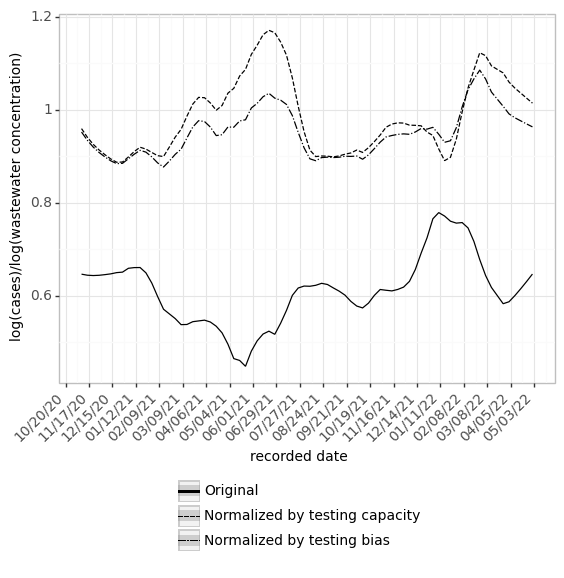

<ggplot: (8733561250465)>

/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


In [254]:
log_log_ratio_weekly_mean_melt.replace({'log_cases_to_log_gmean':'Original',
                                       'log_cases_to_log_gmean_capacity_compensated':'Normalized by testing capacity',
                                       'log_cases_to_log_gmean_testing_compensated':'Normalized by testing bias'},inplace=True
                                       )

categorical = ['Original','Normalized by testing capacity','Normalized by testing bias']
log_log_ratio_weekly_mean_melt.variable = pd.Categorical(log_log_ratio_weekly_mean_melt.variable, categories = categorical)

print(log_log_ratio_weekly_mean_melt.sample_code.unique())

plt = (ggplot(log_log_ratio_weekly_mean_melt,aes(x='date_sampling',y='value',group='variable',linetype='variable'))+
        stat_smooth(method='lowess',span=0.1,size=0.5)+
        xlab('recorded date')+
        ylab('log(cases)/log(wastewater concentration)')+
        theme_bw()+
        theme(panel_border=element_rect(fill='None', color='#BFBFBF'))+
        theme(text=element_text(size=10,family='sans-serif'))+
        scale_x_datetime(breaks = '4 week', labels = date_format('%D'))+
        theme(axis_text_x=element_text(rotation=45, hjust=1))+
        theme(legend_position = 'bottom',
              legend_direction = 'vertical',
              legend_box_spacing = .8,
              legend_title = element_blank()))
display(plt)
ggsave(plt, figS4_path,
#               width = 30,
#               height = 8,
#               units = 'cm',
              dpi = 300,
              verbose=False)

In [256]:
original_std = round(log_log_ratio_weekly_mean.log_cases_to_log_gmean.std(),2)
capacity_compensated_std = round(log_log_ratio_weekly_mean.log_cases_to_log_gmean_capacity_compensated.std(),2)
bias_compensated_std = round(log_log_ratio_weekly_mean.log_cases_to_log_gmean_testing_compensated.std(),2)

print('Original std: ',original_std,
      '\nTesting capacity compensated std: ',capacity_compensated_std,
      '\nTesting bias compensated std: ',bias_compensated_std)

Original std:  0.26 
Testing capacity compensated std:  0.5 
Testing bias compensated std:  0.44


## Figure 5. Time series of log cases, log wastewater and ratio, colored by testing rate

In [ ]:
## Plot all weekly RNA and case values facetted and colored by testing rate
median_perc = (log_log_ratio_weekly_mean.total_tests_by_pop_rolling_avg.median() - log_log_ratio_weekly_mean.total_tests_by_pop_rolling_avg.min()) / (log_log_ratio_weekly_mean.total_tests_by_pop_rolling_avg.max() - log_log_ratio_weekly_mean.total_tests_by_pop_rolling_avg.min())

log_log_ratio_weekly_mean_melt = log_log_ratio_weekly_mean.melt(id_vars=['sample_code','date_sampling'],
                                                                value_vars=['log_gmean','log_cases','log_cases_to_log_gmean'])
                                                          
log_log_ratio_weekly_mean_melt = log_log_ratio_weekly_mean_melt.merge(log_log_ratio_weekly_mean[['sample_code','date_sampling','total_tests_by_pop_rolling_avg']],
                                                                      on=['sample_code','date_sampling'],how='left')


In [258]:
log_log_ratio_weekly_mean_melt.replace({'log_gmean':'log(flow-adj. RNA concentration)',
                                        'log_cases':'log(cases per 100k)',
                                        'log_cases_to_log_gmean':'log(cases)/log(RNA)'},inplace=True)
log_log_ratio_weekly_mean_melt.rename(columns={'total_tests_by_pop_rolling_avg':'daily tests per 100.000 people'},inplace=True)
log_log_ratio_weekly_mean_melt.dropna(subset=['value'],inplace=True)

log_log_ratio_weekly_mean_melt = log_log_ratio_weekly_mean_melt.loc[log_log_ratio_weekly_mean_melt.sample_code.isin(['D1','D2','K','L','M'])]

/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


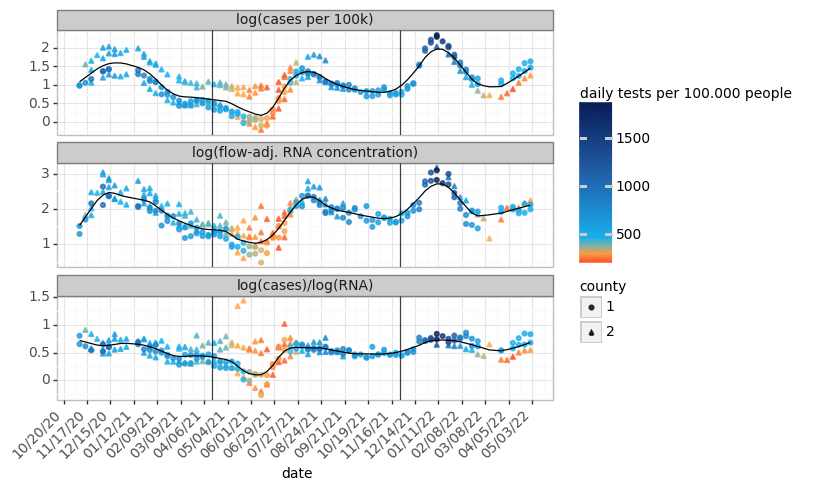

<ggplot: (8733562857197)>

/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


In [260]:
categories = ['log(cases per 100k)','log(flow-adj. RNA concentration)','log(cases)/log(RNA)']
log_log_ratio_weekly_mean_melt.variable = pd.Categorical(log_log_ratio_weekly_mean_melt.variable, categories = categories)

log_log_ratio_weekly_mean_melt['county'] = np.nan
log_log_ratio_weekly_mean_melt.loc[log_log_ratio_weekly_mean_melt.sample_code.isin(['D1','D2']), 'county'] = '1'
log_log_ratio_weekly_mean_melt.loc[log_log_ratio_weekly_mean_melt.sample_code.isin(['K','L','M']), 'county'] = '2'

plt = (ggplot(log_log_ratio_weekly_mean_melt, aes(x='date_sampling', y='value', group = 'variable', color = 'daily tests per 100.000 people', shape = 'county'))+
        geom_point(size=1, stroke=0.75, alpha=0.75)+
        stat_smooth(method='lowess',span=0.1,size=0.5)+
        scale_color_gradientn(colors=['#fc4e2a','#feb24c','#18b2f0','#225ea8','#081d58'],
                        values=[0,0.065,0.13,0.565,1])+
        geom_vline(aes(xintercept=pd.to_datetime('2021-04-15')),alpha=0.75)+
        geom_vline(aes(xintercept=pd.to_datetime('2021-11-26')),alpha=0.75)+
        xlab('date')+
        ylab('')+
        theme_bw()+
        theme(panel_border=element_rect(fill='None', color='#BFBFBF'))+
        theme(text=element_text(size=10,family='sans-serif'))+
        scale_x_datetime(breaks = '4 week', labels = date_format('%D'))+
        theme(axis_text_x=element_text(rotation=45, hjust=1))+
        facet_wrap('variable',ncol=1, scales='free_y'))
display(plt)
ggsave(plt, fig5_path,
              width = 15,
              height = 12,
              units = 'cm',
              # dpi=500,
              verbose=False)

## Table S6. Correlation between testing and log ratio

In [261]:
testing_ratio_corr = pd.DataFrame(columns=['correlation','p'],index=['D1','D2','K','L','M'])
for code in log_log_ratio_weekly_mean_melt.sample_code.unique():
  log_log_ratio_weekly_mean_melt_code = log_log_ratio_weekly_mean_melt.loc[log_log_ratio_weekly_mean_melt.sample_code == code].copy()
  r, p = stats.kendalltau(log_log_ratio_weekly_mean_melt_code.loc[log_log_ratio_weekly_mean_melt_code.variable == 'log(cases)/log(RNA)', 'value'],
                          log_log_ratio_weekly_mean_melt_code.loc[log_log_ratio_weekly_mean_melt_code.variable == 'log(cases)/log(RNA)', 'daily tests per 100.000 people'])
  testing_ratio_corr.loc[code,'correlation'] = r
  testing_ratio_corr.loc[code,'p'] = p

testing_ratio_corr.to_csv(tableS7_path,index=True)

## Figure S5

min max rescale

In [264]:
log_log_ratio_smooth = all[['sample_code','date_sampling','log_cases','log_gmean','log_cases_to_log_gmean']].loc[all.sample_code.isin(['D1','D2','K','L','M'])].copy()
log_log_ratio_smooth.drop(columns=['sample_code'],inplace=True)
log_log_ratio_smooth.date_sampling = log_log_ratio_smooth.date_sampling.astype('datetime64[ns]')

In [265]:
log_log_ratio_smooth.set_index(['date_sampling'],inplace=True)
log_log_ratio_smooth = log_log_ratio_smooth.groupby(pd.Grouper(freq='D')).mean()
log_log_ratio_smooth.reset_index(inplace=True)

In [ ]:
day0 = log_log_ratio_smooth.date_sampling.min()
log_log_ratio_smooth['day'] = log_log_ratio_smooth.date_sampling - day0
log_log_ratio_smooth.day = log_log_ratio_smooth.day.dt.days

smoothed_df_all = pd.DataFrame(columns=['day'])
lowess = statsmodels.nonparametric.smoothers_lowess.lowess # define lowess

# Smooth all variables 
for var in ['log_cases','log_gmean','log_cases_to_log_gmean']:
  log_log_ratio_smooth_var = log_log_ratio_smooth[['day',var]].copy()

  log_log_ratio_smooth_dropna = log_log_ratio_smooth_var.dropna(subset=[var])
  var_min_date = log_log_ratio_smooth_dropna.day.min()
  var_max_date = log_log_ratio_smooth_dropna.day.max()

  log_log_ratio_smooth_var = log_log_ratio_smooth_var[(log_log_ratio_smooth_var.day >= var_min_date)&
                                                      (log_log_ratio_smooth_var.day <= var_max_date)]
  
  # Define lowess smoother
  total_samples = len(log_log_ratio_smooth_var.dropna(subset=[var]))
  frac = 20 / total_samples # define lowess alpha parameter as n=5 data points

  # Define x values (time) of lowess function to evaluate
  xvals = log_log_ratio_smooth_var.day.unique()

  endog = log_log_ratio_smooth_dropna.loc[:,var].to_numpy() # Define y variable (to smooth) of lowess function
  exog = log_log_ratio_smooth_dropna.day.to_numpy()

  xvals = xvals.astype(float)

  smoothed_np = lowess(endog=endog, exog=exog, xvals = xvals, frac = frac, it = 0) # smooth, it=0 means no residual-based reweighting

  smoothed_df = pd.DataFrame()
  smoothed_df['day'] = xvals
  smoothed_df[var] = smoothed_np

  smoothed_df_all = smoothed_df_all.merge(smoothed_df,on=['day'],how='outer')

smoothed_df_all.day = pd.to_timedelta(smoothed_df_all.day,unit='days')
smoothed_df_all['date_sampling'] = smoothed_df_all.day + day0

In [268]:
# Rescale based on: (x - xmix) / (xmax - xmin)
smoothed_df_all['log_cases_rescaled'] = (smoothed_df_all.log_cases - \
                                        smoothed_df_all.log_cases.min()) / \
                                        (smoothed_df_all.log_cases.max() - \
                                        smoothed_df_all.log_cases.min())
smoothed_df_all['log_gmean_rescaled'] = (smoothed_df_all.log_gmean - \
                                        smoothed_df_all.log_gmean.min()) / \
                                        (smoothed_df_all.log_gmean.max() - \
                                        smoothed_df_all.log_gmean.min())
smoothed_df_all['log_cases_to_log_gmean_rescaled'] = (smoothed_df_all.log_cases_to_log_gmean - \
                                                      smoothed_df_all.log_cases_to_log_gmean.min()) / \
                                                      (smoothed_df_all.log_cases_to_log_gmean.max() - \
                                                      smoothed_df_all.log_cases_to_log_gmean.min())

In [269]:
smoothed_df_all_melt = smoothed_df_all.melt(id_vars=['date_sampling'],
                                                value_vars=['log_cases_to_log_gmean_rescaled',
                                                          'log_cases_rescaled',
                                                          'log_gmean_rescaled'])

/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 3 rows containing missing values.


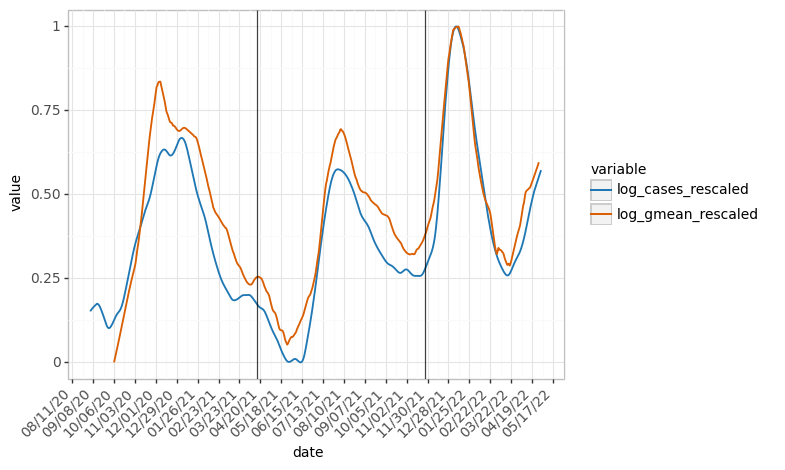

<ggplot: (8733562771621)>

/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 3 rows containing missing values.


In [270]:
smoothed_df_all_melt = smoothed_df_all_melt.loc[smoothed_df_all_melt.variable.isin(['log_cases_rescaled','log_gmean_rescaled'])].copy()
colors = {'log_gmean_rescaled':'#d95f02', 'log_cases_rescaled':'#1f78b4','log_cases_to_log_gmean_rescaled':'gray'}  

plt = (ggplot(smoothed_df_all_melt, aes(x='date_sampling', y='value', group = 'variable', color = 'variable'))+
        geom_line(size=0.75)+
        geom_vline(aes(xintercept=pd.to_datetime('2021-04-15')),alpha=0.75)+
        geom_vline(aes(xintercept=pd.to_datetime('2021-11-26')),alpha=0.75)+
        xlab('date')+
        scale_color_manual(values=colors)+
        theme_bw()+
        theme(panel_border=element_rect(fill='None', color='#BFBFBF'))+
        theme(text=element_text(size=10,family='sans-serif'))+
        scale_x_datetime(breaks = '4 week', labels = date_format('%D'))+
        theme(axis_text_x=element_text(rotation=45, hjust=1)))
display(plt)
ggsave(plt, fig5_new_path,
              width = 15,
              height = 12,
              units = 'cm',
              verbose=False)

# Regression

Prepare data for regression

In [ ]:
log_for_reg = pd.DataFrame() # new df
log_for_reg = all[['sample_code','date_sampling','log_cases','log_gmean']].copy()
log_for_reg.date_sampling = log_for_reg.date_sampling.astype('datetime64[ns]') # Adapt data type

# drop where case data unavailable
log_for_reg.dropna(subset=['log_cases'],inplace=True)
display(log_for_reg.head())

Defined timeframe linear regression for 7 best sites

In [ ]:
# define plot colors
colors = {'gmean':'#b2df8a', 'reported cases':'#a6cee3','predicted cases':'#1f78b4'}  

# sample_codes = log_for_reg.sample_code.unique()
sample_codes = ['D1','D2','K','L','M']

# initialize modeling result df
R2_summary = pd.DataFrame(columns=['slope','intercept','training_R2','delta_R2','omicron_R2'],index=sample_codes)

# Initialize regression
reg = linear_model.LinearRegression()

for code in sample_codes: # iterate over every sampling location
  print(code)
  # Filter dataset for this sampling location
  log_for_reg_sample_code = log_for_reg.loc[log_for_reg.sample_code == code][['date_sampling','log_cases','log_gmean']].copy()
  
  # Initialize cases_prediction_full
  cases_prediction_full = pd.DataFrame(columns=['dates','value','variable'])
  
  ## Clip training data
  gmean_dates = log_for_reg_sample_code.dropna(subset=['log_gmean']).date_sampling.copy()
  training_start = gmean_dates.min()
  training_end = variant_timeframes.loc['delta','start']
  if training_start >= training_end:
    continue
  training_dates = gmean_dates.loc[(gmean_dates >= training_start) & (gmean_dates <= training_end)] # save dates for plotting
  genes_cases_df = log_for_reg_sample_code.loc[(log_for_reg_sample_code.date_sampling >= training_start) & 
                                              (log_for_reg_sample_code.date_sampling <= training_end)][['log_gmean','log_cases']].copy()
  genes_cases_df.dropna(inplace=True) # regression can't handle nans
  genes_training = genes_cases_df['log_gmean'].to_numpy().reshape((-1, 1)) # reshape x to have one column and as many rows as necessary (matrix form)
  cases_training = genes_cases_df['log_cases'].to_numpy() # keep in array form

  ## Create model
  regfit = reg.fit(genes_training,cases_training)
  slope = reg.coef_[0]
  intercept = reg.intercept_
  print('slope = ',slope) # model slope
  print('intercept = ',intercept) # model intercept
  R_squared_train = reg.score(genes_training,cases_training)
  print('training R2 = ',R_squared_train) # model R squared

  cases_prediction_during_training = pd.DataFrame(columns=['dates','predicted cases'])
  cases_prediction_during_training.loc[:,'predicted cases'] = np.power(10,reg.predict(genes_training)) # predict cases
  cases_prediction_during_training_log = cases_prediction_during_training.copy()
  cases_prediction_during_training_log.loc[:,'predicted cases'] = reg.predict(genes_training) # predict cases
  training_dates_df = pd.DataFrame(columns=['dates'])
  training_dates_df.loc[:,'dates'] = training_dates
  training_dates_df.reset_index(inplace=True)
  cases_prediction_during_training.loc[:,'dates'] = training_dates_df.loc[:,'dates']
  cases_prediction_during_training_log.loc[:,'dates'] = training_dates_df.loc[:,'dates']

  
  prediction_bool = ['delta','omicron_BA1','all']
  for prediction_timeframe in prediction_bool:
    ### Clip prediction data as numpy array y containing everything after training
    print('Predict: ',prediction_timeframe)
    prediction_start = variant_timeframes.loc[prediction_timeframe,'start']
    prediction_end = variant_timeframes.loc[prediction_timeframe,'end']
    
    print('prediction start: ',prediction_start,', prediction end: ',prediction_end)

    # Calculate prediction
    prediction_dates = gmean_dates.loc[(gmean_dates > training_end) & (gmean_dates <= prediction_end)] # save dates for plotting
    genes_prediction = log_for_reg_sample_code.loc[(log_for_reg_sample_code.date_sampling > training_end) & 
                                                  (log_for_reg_sample_code.date_sampling <= prediction_end),'log_gmean']
    genes_prediction.dropna(inplace=True) # regression can't handle nans
    genes_prediction = genes_prediction.to_numpy().reshape((-1, 1)) # reshape x to have one column and as many rows as necessary (matrix form)
    cases_prediction = reg.predict(genes_prediction) # predict cases

    # Plot training & prediction
    training_temp = pd.DataFrame(columns=['dates','gmean','cases'])
    training_temp.dates = training_dates
    training_temp.gmean = np.power(10,genes_cases_df.log_gmean)
    training_temp.loc[:,'reported cases'] = np.power(10,genes_cases_df.log_cases)
    training_temp_log = training_temp.copy()
    training_temp_log.gmean = genes_cases_df.log_gmean
    training_temp_log.loc[:,'reported cases'] = genes_cases_df.log_cases

    prediction_temp = pd.DataFrame(columns=['dates','gmean','predicted cases','reported cases'])
    prediction_temp.loc[:,'dates'] = prediction_dates
    prediction_temp.loc[:,'gmean'] = np.power(10,genes_prediction)
    prediction_temp.loc[:,'predicted cases'] = np.power(10,cases_prediction)
    prediction_temp_log = prediction_temp.copy()
    prediction_temp_log.loc[:,'gmean'] = genes_prediction
    prediction_temp_log.loc[:,'predicted cases'] = cases_prediction

    # Add original case data during prediction timeframe
    orig_cases_df = log_for_reg_sample_code.loc[(log_for_reg_sample_code.date_sampling >= training_end)]['log_cases']
    prediction_temp.loc[:,'reported cases'] = np.power(10,orig_cases_df)
    prediction_temp_log.loc[:,'reported cases'] = orig_cases_df

    ## Calculate fit for training timeframe, Omicron, Delta (maybe before & after peak separately because of vaccinations?)
    # Calculate fit between actual cases and predicted cases
    cases_predicted = prediction_temp.loc[:,'predicted cases'].to_numpy()
    cases_orig = prediction_temp.loc[:,'reported cases'].to_numpy()
    R_squared = metrics.r2_score(cases_orig,cases_predicted)
    # print('prediction R2 = ',R_squared) # model R squared

    ### Save modeling data
    # R2_summary = pd.Dataframe(columns=['sample_code','slope','intercept','training_R2','all_R2','delta_R2','omicron_R2'])
    R2_summary.loc[code,'slope'] = round(slope,2)
    R2_summary.loc[code, 'intercept'] = round(intercept,2)
    R2_summary.loc[code,'training_R2'] = round(R_squared_train,2)
    if prediction_timeframe == 'delta':
      R2_summary.loc[code, 'delta_R2'] = round(R_squared,2)
    elif prediction_timeframe == 'omicron_BA1':
      R2_summary.loc[code, 'omicron_R2'] = round(R_squared,2)

    ### Plot actual and predicted case data (only plot all)
    elif prediction_timeframe == 'all':
      # Melt & concat
      training_temp = training_temp.melt(id_vars=['dates'],value_vars=['gmean','reported cases'])
      prediction_temp = prediction_temp.melt(id_vars=['dates'],value_vars=['gmean','predicted cases','reported cases'])
      cases_prediction_during_training = cases_prediction_during_training.melt(id_vars=['dates'],value_vars=['predicted cases'])
      cases_prediction_full = pd.concat([training_temp,prediction_temp,cases_prediction_during_training])

      plot_title = 'slope = ' + str(round(slope,2)) + ', R2 = ' + str(round(R_squared,2))

      cases_prediction_full = cases_prediction_full.loc[cases_prediction_full.variable != 'gmean']
      frac = 5 / len(cases_prediction_full.loc[cases_prediction_full.variable == 'reported cases'])
      print('frac = ',f'{frac:.2E}',' ',round(frac,4)) 

      plt = (ggplot(cases_prediction_full, aes(x='dates', y='value', group='variable',color='variable'))+
            geom_point(size=1, alpha=0.75)+
            stat_smooth(method='lowess',span=frac)+
            xlab('recorded date')+
            ylab('daily COVID-19 cases per 100,000')+
            geom_vline(xintercept=training_dates.tail(1),linetype='dashed',color='gray')+
            scale_y_log10()+
            labs(title=code)+
            # annotate('label', x=datetime.datetime(2020, 10, 20), y=mean_a, label='{:.1f}'.format(mean_a), color='#770d50', size=8, label_size=0.2)+
            scale_color_manual(values=colors)+
            theme(axis_text_x=element_text(rotation=45, hjust=1))+
            scale_x_datetime(breaks = '4 week', labels = date_format('%D')))
            # theme(legend.position = 'bottom'))
      display(plt)
      
      # reset vars for iteration
      del prediction_start, prediction_end, prediction_dates, genes_prediction, cases_prediction, training_temp, prediction_temp, orig_cases_df
      del cases_predicted, cases_orig, R_squared #, cases_prediction_full

# save prediction R2 in csv file
R2_summary.to_csv(R2_path,index=True)